# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data analysis
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal as signal
from scipy.stats import t
import xarray as xr
import xrft

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

# import colormaps as cmaps
sys.path.insert(0, "/glade/u/home/sressel/auxiliary_functions/")
import mjo_mean_state_diagnostics as mjo
from bmh_colors import bmh_colors
from one_two_one_filter import one_two_one_filter
from rounding_functions import round_out
from tick_labeller import tick_labeller
from standardize_data import standardize_data

from processing_functions import time_filter_data, mjo_filter_data
from load_aquaplanet_data import *

print("Imports loaded")

Loading imports...
Imports loaded


# Specify parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Column MSE Budgets

## 3-hourly model-level data

In [3]:
def beta_column_integrate(pressure_array, variable, surface_pressure, pbot, ptop):
    """
    Perform vertical integration of a variable using Trenberth (1991) beta factors.

    This function computes the vertical integral of an atmospheric variable
    using pressure levels and surface pressure, accounting for partial layer
    contributions via the beta factor method described by Trenberth (1991).

    Parameters
    ----------
    pressure_array : xarray.DataArray
        A 4D array of pressure values with dimensions (time, lat, lon, index),
        where `index` refers to the midpoint of pressure layers (odd-indexed).

    variable : xarray.DataArray
        A 4D array of the variable to be integrated, with dimensions
        (time, lat, lon, lev), where `lev` matches the vertical structure
        of `pressure_array` (e.g., pressure levels).

    surface_pressure : xarray.DataArray
        A 3D array (time, lat, lon) of surface pressure values.

    pbot : float
        Bottom pressure level (e.g., 100000 Pa for surface).

    ptop : float
        Top pressure level for integration. Layers above this will be excluded.

    Returns
    -------
    column_integrated_variable : xarray.DataArray
        A 3D array (time, lat, lon) of the vertically integrated variable
        in units adjusted by the factor (1 / 9.81), representing integration
        over pressure coordinates.

    Notes
    -----
    - The function constructs intermediate pressure levels at layer boundaries
      using the input `pressure_array`, and computes thicknesses and beta
      weighting factors accordingly.
    - The integration accounts for whether each layer is fully or partially
      beneath the surface using the surface pressure and beta factor.
    - Any layers with pressure less than `ptop` are excluded from the integration.

    References
    ----------
    Trenberth, K. E. (1991). Climate diagnostics from global analyses:
    Conservation of mass in ECMWF analyses. Journal of Climate, 4(7), 707–722.
    """

    # Convert the pressure array to be bottom-to-top, and to have index labels instead of level labels
    pressure_array = pressure_array.transpose(..., "lev")
    pressure_array = pressure_array.isel(lev=slice(None, None,-1))
    pressure_array = pressure_array.assign_coords(lev=("lev", np.arange(1, 2*len(pressure_array.lev), 2)))
    pressure_array = pressure_array.rename({'lev':'index'})

    fill_value = 0

    original_shape = list(pressure_array.shape)
    original_dims = list(pressure_array.dims)
    original_coords = pressure_array.coords

    # Modify shape: extend the last dimension by 1
    extended_shape = original_shape.copy()
    extended_shape[-1] += 1

    # Create extended coordinates for the last dimension
    last_dim = original_dims[-1]
    last_coord = original_coords[last_dim].values
    extended_last_coord = np.arange(0, 2*len(pressure_array.index)+2, 2)

    # Create a dict of coordinates, extending only the last dimension
    extended_coords = {
        dim: (original_coords[dim].values if dim != last_dim else extended_last_coord)
        for dim in original_dims
    }

    # Create the data with desired fill_value (e.g. zeros)
    intermediate_levels = xr.DataArray(
        data = np.full(extended_shape, fill_value, dtype=pressure_array.dtype),
        dims = pressure_array.dims,
        coords = extended_coords
    )

    # # Calculate the intermediate pressure levels
    # intermediate_levels = xr.DataArray(
    #     data=np.zeros((
    #         len(pressure_array.time),
    #         len(pressure_array.lat),
    #         len(pressure_array.lon),
    #         len(pressure_array.index)+1
    #     )),
    #     # dims=["time", "lat", "lon", "index"],
    #     dims=[*pressure_array.dims]
    #     coords={
    #         'time': pressure_array.time,
    #         'lat': pressure_array.lat,
    #         'lon': pressure_array.lon,
    #         'index': np.arange(0, 2*len(pressure_array.index)+2, 2)
    #     }
    # )

    intermediate_levels[..., 0] = pbot*np.ones_like(surface_pressure.values)
    intermediate_levels[..., 1:-1] = 0.5*(pressure_array[..., :-1].values + pressure_array[..., 1:].values)
    intermediate_levels[..., -1] = np.zeros_like(surface_pressure.values)

    # Calculate the thickness of each layer
    pressure_jminus1 = intermediate_levels[..., :-1].values
    pressure_jplus1 = intermediate_levels[..., 1:].values
    layer_thickness = xr.zeros_like(pressure_array)
    layer_thickness[..., :] = pressure_jminus1 - pressure_jplus1

    # Calculate the Trenberth beta factors
    reshaped_surface_pressure = surface_pressure.expand_dims(
        dim={"index": pressure_array.index},
        axis=surface_pressure.ndim
    )

    lower_one_condition = (pressure_jminus1 < reshaped_surface_pressure)
    lower_zero_condition = (pressure_jplus1 > reshaped_surface_pressure)
    lower_beta = xr.where(
        lower_one_condition, 1,
        xr.where(
            lower_zero_condition, 0, (
                (reshaped_surface_pressure - pressure_jplus1)
                / (pressure_jminus1 - pressure_jplus1)
            )
        )
    )

    upper_one_condition = (pressure_jplus1 > ptop)
    upper_zero_condition = (pressure_jminus1 < ptop)
    upper_beta = xr.where(
        upper_one_condition, 1,
        xr.where(
            upper_zero_condition, 0, (
                (pressure_jminus1 - ptop)
                / (pressure_jminus1 - pressure_jplus1)
            )
        )
    )

    # Re-order and label the variable to be integrated
    relabelled_variable = variable.isel(lev=slice(None, None, -1))
    relabelled_variable = relabelled_variable.assign_coords(lev=("lev", np.arange(1, 2*len(pressure_array.index), 2)))
    relabelled_variable = relabelled_variable.rename({'lev': 'index'})

    # Calculate the vertical integral
    column_integrated_variable = (1/9.8)*(
        lower_beta*relabelled_variable*layer_thickness*upper_beta
        # lower_beta*relabelled_variable*layer_thickness*
    ).sum(dim='index')
    return column_integrated_variable


def vertical_pressure_gradient(input_variable, input_pressure_array, units='hPa'):
    """
    Calculate the vertical pressure gradient of a variable using finite differences.

    Parameters
    ----------
    input_variable : xarray.DataArray
        The variable for which the vertical pressure gradient is to be calculated.
        Must include a vertical dimension named 'lev'.

    input_pressure_array : xarray.DataArray
        The pressure values corresponding to each vertical level. Must have the
        same shape and dimensions as `input_variable`, including the 'lev' dimension.

    Returns
    -------
    xarray.DataArray
        The vertical gradient of `input_variable` with respect to pressure,
        with the same dimensions and shape as the input.

    Notes
    -----
    - The gradient is computed using:
        - Forward difference at the bottom boundary (lev=0)
        - Central difference for interior levels (1 <= lev <= N-2)
        - Backward difference at the top boundary (lev=N-1)
    - Assumes pressure decreases with height (as in atmospheric applications).
    """

    # Reorient the input data so that the vertical level dimension 'lev' is last
    variable = input_variable.transpose(..., "lev")
    pressure_array = input_pressure_array.transpose(..., "lev")

    # Create an output array of zeros with the same shape as the input variable
    vertical_gradient = xr.zeros_like(variable)

    # Compute the forward difference for the bottom-most level (lev=0)
    vertical_gradient[..., 0] = (
        (variable[..., 1].values - variable[..., 0].values)
        / (pressure_array[..., 1].values - pressure_array[..., 0].values)
    )

    # Compute the central difference for interior levels (lev=1 to lev=-2)
    vertical_gradient[..., 1:-1] = (
        (variable[..., 2:].values - variable[..., :-2].values)
        / (pressure_array[..., 2:].values - pressure_array[..., :-2].values)
    )

    # Compute the backward difference for the top-most level (lev=-1)
    vertical_gradient[..., -1] = (
        (variable[..., -1].values - variable[..., -2].values)
        / (pressure_array[..., -1].values - pressure_array[..., -2].values)
    )

    # Revert to the original dimension ordering of the input variable
    output_vertical_gradient = vertical_gradient.transpose(*input_variable.dims)

    if units == 'hPa':
        output_vertical_gradient /= 100

    return output_vertical_gradient

In [4]:
save_column_integrated_data = True

# Initialize arrays for budget variables
column_MSE = {}
column_MSE_tendency = {}
column_zonal_advection = {}
column_meridional_advection = {}
column_vertical_advection = {}
column_latent_heating = {}
column_sensible_heating = {}
column_longwave_heating = {}
column_shortwave_heating = {}
column_residual = {}

n_calculations = 11
experiments_list = ['-4K', '0K', '4K']

variables_loaded = {}
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    recalculate_budgets = True

    non_timed_data =  xr.open_dataset(
        rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
    )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")
        lower_level_pressure = 1100.*100.
        # upper_level_pressure = 100.*100.
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
        temperature_minimum_index = time_mean_temperature.argmin('lev')
        temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
        upper_level_pressure = temperature_minimum_pressure_level.values

        print(f"{'Moist Static Energy...':<{str_width-1}}", end="")
        GRAVITY = 9.8                        #  m/s^2
        SPECIFIC_HEAT = 1005.7               #  J/Kg*K ; specific heat at constant pressure for dry air
        HEAT_OF_VAPORIZATION = 2.501e6       #  [J/kg]=[m2/s2]  Latent Heat of Vaporization at 0
        HEAT_OF_FUSION = 3.337e5             # [J/kg]=[m2/s2]  Latent Heat of Sublimation at 0
        moist_static_energy = (
            HEAT_OF_VAPORIZATION*variables_loaded['Q']
            - HEAT_OF_FUSION*variables_loaded['CLDICE']
            + SPECIFIC_HEAT*variables_loaded['T']
            + GRAVITY*variables_loaded['Z3']
        )
        moist_static_energy.name = 'Moist Static Energy'
        moist_static_energy.attrs['units'] = r"J kg$^{-2}$"
        print(rf"{'✔':>1}")

        print(f"{'MSE Tendency...':<{str_width-1}}", end="")
        MSE_tendency = (
            (1/SECONDS_PER_DAY)
            * moist_static_energy.differentiate('time', datetime_unit='D')
        )
        MSE_tendency.name = 'MSE Tendency'
        MSE_tendency.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        print(f"{'Zonal Advection...':<{str_width-1}}", end="")
        zonal_MSE_gradient = (
            (180/np.pi)
            * moist_static_energy.differentiate('lon')
            / (EARTH_RADIUS*np.cos(np.deg2rad(moist_static_energy.lat)))
        )
        zonal_advection = -variables_loaded['U']*zonal_MSE_gradient
        zonal_advection.name = 'Zonal Advection'
        zonal_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        print(f"{'Meridional Advection...':<{str_width-1}}", end="")
        meridional_MSE_gradient = (
            (180/np.pi)
            * moist_static_energy.differentiate('lat')
            / EARTH_RADIUS
        )

        meridional_advection = -variables_loaded['V'] * meridional_MSE_gradient
        meridional_advection.name = 'Meridional Advection'
        meridional_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        print(f"{'Vertical Advection...':<{str_width-1}}", end="")
        # vertical_MSE_gradient = (1/100)*moist_static_energy.differentiate('lev')
        vertical_MSE_gradient = xr.zeros_like(moist_static_energy)
        vertical_MSE_gradient[:, 0] = (
            (moist_static_energy[:, 1].values - moist_static_energy[:, 0].values)
            / (pressure_array[:, 1].values - pressure_array[:, 0].values)
        )
        vertical_MSE_gradient[:, 1:-1] = (
            (moist_static_energy[:, 2:].values - moist_static_energy[:, :-2].values)
            / (pressure_array[:, 2:].values - pressure_array[:, :-2].values)
        )
        vertical_MSE_gradient[:, -1] = (
            (moist_static_energy[:, -1].values - moist_static_energy[:, -2].values)
            / (pressure_array[:, -1].values - pressure_array[:, -2].values)
        )

        vertical_advection = -variables_loaded['OMEGA'] * vertical_MSE_gradient
        vertical_advection.name = 'Vertical Advection'
        vertical_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        print(f"{'Column integrating...':<{str_width-1}}", end="")
        # MSE
        column_MSE[experiment] = beta_column_integrate(
            pressure_array,
            moist_static_energy,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_MSE[experiment].name = 'Moist Static Energy'
        column_MSE[experiment].attrs = {}
        column_MSE[experiment].attrs['long_name'] = 'Frozen Moist Static Energy'
        column_MSE[experiment].attrs['math_name'] = r"$\langle$m$\rangle$"
        column_MSE[experiment].attrs['units'] = r"J m$^{-2}$"

        # MSE Tendency
        column_MSE_tendency[experiment] = beta_column_integrate(
            pressure_array,
            MSE_tendency,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_MSE_tendency[experiment].name = 'MSE Tendency'
        column_MSE_tendency[experiment].attrs = {}
        column_MSE_tendency[experiment].attrs['long_name'] = "Moist Static Energy Tendency"
        column_MSE_tendency[experiment].attrs['math_name'] = r"$\langle$$\partial_{t}$m$\rangle$"
        column_MSE_tendency[experiment].attrs['units'] = r"W m$^{-2}$"

        # Zonal MSE Advection
        column_zonal_advection[experiment] = beta_column_integrate(
            pressure_array,
            zonal_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_zonal_advection[experiment].name = 'Zonal Advection'
        column_zonal_advection[experiment].attrs = {}
        column_zonal_advection[experiment].attrs['long_name'] = "Zonal Advection of Moist Static Energy"
        column_zonal_advection[experiment].attrs['math_name'] = r"$-\langle$$u \partial_{x}$m$\rangle$"
        column_zonal_advection[experiment].attrs['units'] = r"W m$^{-2}$"

        # Meridional MSE Advection
        column_meridional_advection[experiment] = beta_column_integrate(
            pressure_array,
            meridional_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_meridional_advection[experiment].name = 'Meridional Advection'
        column_meridional_advection[experiment].attrs = {}
        column_meridional_advection[experiment].attrs['long_name'] = "Meridional Advection of Moist Static Energy"
        column_meridional_advection[experiment].attrs['math_name'] = r"$-\langle$$v \partial_{y}$m$\rangle$"
        column_meridional_advection[experiment].attrs['units'] = r"W m$^{-2}$"

        # Vertical MSE Advection
        column_vertical_advection[experiment] = beta_column_integrate(
            pressure_array,
            vertical_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_vertical_advection[experiment].name = 'Vertical Advection'
        column_vertical_advection[experiment].attrs = {}
        column_vertical_advection[experiment].attrs['long_name'] = "Vertical Advection of Moist Static Energy"
        column_vertical_advection[experiment].attrs['math_name'] = r"$-\langle$$ω \partial_{p}$m$\rangle$"
        column_vertical_advection[experiment].attrs['units'] = r"W m$^{-2}$"
        print(rf"{'✔':>1}")

        # Latent Heating
        column_latent_heating[experiment] = variables_loaded['LHFLX']
        column_latent_heating[experiment].name = 'Latent Heating'
        column_latent_heating[experiment].attrs = {}
        column_latent_heating[experiment].attrs['long_name'] = "Surface Latent Heat Flux"
        column_latent_heating[experiment].attrs['math_name'] = r"LH"
        column_latent_heating[experiment].attrs['units'] = r"W m$^{-2}$"

        # Sensible Heating
        column_sensible_heating[experiment] = variables_loaded['SHFLX']
        column_sensible_heating[experiment].name = 'Sensible Heating'
        column_sensible_heating[experiment].attrs = {}
        column_sensible_heating[experiment].attrs['long_name'] = "Surface Sensible Heat Flux"
        column_sensible_heating[experiment].attrs['math_name'] = r"SH"
        column_sensible_heating[experiment].attrs['units'] = r"W m$^{-2}$"

        # Longwave Heating
        column_longwave_heating[experiment] = (variables_loaded['FLNS'] - variables_loaded['FLNT'])
        column_longwave_heating[experiment].name = 'Longwave Heating'
        column_longwave_heating[experiment].attrs = {}
        column_longwave_heating[experiment].attrs['long_name'] = "Net Longwave Radiative Flux"
        column_longwave_heating[experiment].attrs['math_name'] = r"$\langle$LW$\rangle$"
        column_longwave_heating[experiment].attrs['units'] = r"W m$^{-2}$"

        # Shortwave Heating
        column_shortwave_heating[experiment] = (variables_loaded['FSNT'] - variables_loaded['FSNS'])
        column_shortwave_heating[experiment].name = 'Shortwave Heating'
        column_shortwave_heating[experiment].attrs = {}
        column_shortwave_heating[experiment].attrs['long_name'] = "Net Shortwave Radiative Flux"
        column_shortwave_heating[experiment].attrs['math_name'] = r"$\langle$SW$\rangle$"
        column_shortwave_heating[experiment].attrs['units'] = r"W m$^{-2}$"

        # Residual
        estimated_column_MSE_tendency = (
            + column_vertical_advection[experiment]
            + column_zonal_advection[experiment]
            + column_meridional_advection[experiment]
            + column_latent_heating[experiment]
            + column_sensible_heating[experiment]
            + column_longwave_heating[experiment]
            + column_shortwave_heating[experiment]
        )

        column_residual[experiment] = column_MSE_tendency[experiment] - estimated_column_MSE_tendency
        column_residual[experiment].name = 'Residual'
        column_residual[experiment].attrs = {}
        column_residual[experiment].attrs['long_name'] = r"Residual"
        column_residual[experiment].attrs['math_name'] = r"Res."
        column_residual[experiment].attrs['units'] = r"W m$^{-2}$"

MSE_budget_variables = {
    'Moist Static Energy': column_MSE,
    'Moist Static Energy Tendency': column_MSE_tendency,
    'Zonal Advection': column_zonal_advection,
    'Meridional Advection': column_meridional_advection,
    'Vertical Advection': column_vertical_advection,
    'Latent Heating': column_latent_heating,
    'Sensible Heating': column_sensible_heating,
    'Longwave Heating': column_longwave_heating,
    'Shortwave Heating': column_shortwave_heating,
    'Residual': column_residual
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(MSE_budget_variables):
    print(f"{f'({index+1}/{len(MSE_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [MSE_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    print(rf"{'✔':>1}")

if save_column_integrated_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/MSE_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            # response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            response = 'y'
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
Moist Static Energy...                 ✔
MSE Tendency...                        ✔
Zonal Advection.

In [ ]:
save_column_integrated_data = True

# Initialize arrays for budget variables
# column_MSE = {}
# column_MSE_tendency = {}
# column_zonal_advection = {}
# column_meridional_advection = {}
# column_vertical_advection = {}
# column_latent_heating = {}
# column_sensible_heating = {}
# column_longwave_heating = {}
# column_shortwave_heating = {}
# column_residual = {}

n_calculations = 11
experiments_list = ['-4K', '0K', '4K']

variables_to_load = [
    "PS",
    "T",
    "Q",
    "Z3",
    "CLDICE",
    "U",
    "V",
    "OMEGA",
    "LHFLX",
    "SHFLX",
    "FLNT",
    "FLNS",
    "FSNT",
    "FSNS",
]
multi_experiment_variables_loaded = load_multi_experiment_daily_model_level_data(
    variables_to_load,
    multi_experiment_variables_loaded
)

non_timed_data =  xr.open_dataset(
    rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
)

recalculate_budgets = False
print(f"{'Calculate budget terms':^{str_width}}")
print(f"{'='*str_width}")
if not 'pressure_array' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Pressure Array...':<{str_width-1}}", end="")
    lower_level_pressure = 1100.*100.
    upper_level_pressure = 100.*100.
    surface_pressure = multi_experiment_variables_loaded['PS']
    pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
    pressure_array = pressure_array.transpose("experiment", "time", "lev", "lat", "lon")
else:
    print(f"{'Pressure array exists...':<{str_width-1}}", end="")
print(rf"{'✔':>1}")

if not 'moist_static_energy' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Moist Static Energy...':<{str_width-1}}", end="")
    GRAVITY = 9.8                        #  m/s^2
    SPECIFIC_HEAT = 1005.7               #  J/Kg*K ; specific heat at constant pressure for dry air
    HEAT_OF_VAPORIZATION = 2.501e6       #  [J/kg]=[m2/s2]  Latent Heat of Vaporization at 0
    HEAT_OF_FUSION = 3.337e5             # [J/kg]=[m2/s2]  Latent Heat of Sublimation at 0
    moist_static_energy = (
        HEAT_OF_VAPORIZATION*multi_experiment_variables_loaded['Q']
        - HEAT_OF_FUSION*multi_experiment_variables_loaded['CLDICE']
        + SPECIFIC_HEAT*multi_experiment_variables_loaded['T']
        + GRAVITY*multi_experiment_variables_loaded['Z3']
    )
else:
    print(f"{'Moist Static Energy exists...':<{str_width-1}}", end="")
moist_static_energy.name = 'Moist Static Energy'
moist_static_energy.attrs['units'] = r"J kg$^{-2}$"
print(rf"{'✔':>1}")

if not 'MSE_tendency' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating MSE Tendency...':<{str_width-1}}", end="")
    MSE_tendency = (
        (1/SECONDS_PER_DAY)
        * moist_static_energy.differentiate('time', datetime_unit='D')
    )
else:
    print(f"{'MSE Tendency exists...':<{str_width-1}}", end="")
MSE_tendency.name = 'MSE Tendency'
MSE_tendency.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
print(rf"{'✔':>1}")

if not 'zonal_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Zonal Advection...':<{str_width-1}}", end="")
    zonal_MSE_gradient = (
        (180/np.pi)
        * moist_static_energy.differentiate('lon')
        / (EARTH_RADIUS*np.cos(np.deg2rad(moist_static_energy.lat)))
    )
    zonal_advection = -multi_experiment_variables_loaded['U']*zonal_MSE_gradient
else:
    print(f"{'Zonal Advection exists...':<{str_width-1}}", end="")
zonal_advection.name = 'Zonal Advection'
zonal_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
print(rf"{'✔':>1}")

if not 'meridional_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Meridional Advection...':<{str_width-1}}", end="")
    meridional_MSE_gradient = (
        (180/np.pi)
        * moist_static_energy.differentiate('lat')
        / EARTH_RADIUS
    )

    meridional_advection = -multi_experiment_variables_loaded['V'] * meridional_MSE_gradient
else:
    print(f"{'Meridional Advection exists...':<{str_width-1}}", end="")
meridional_advection.name = 'Meridional Advection'
meridional_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
print(rf"{'✔':>1}")

if not 'vertical_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Vertical Advection...':<{str_width-1}}", end="")
    # vertical_MSE_gradient = (1/100)*moist_static_energy.differentiate('lev')
    # vertical_MSE_gradient = xr.zeros_like(moist_static_energy)

    # vertical_MSE_gradient[..., 0] = (
    #     (moist_static_energy[..., 1].values - moist_static_energy[..., 0].values)
    #     / (pressure_array[..., 1].values - pressure_array[..., 0].values)
    # )
    # vertical_MSE_gradient[..., 1:-1] = (
    #     (moist_static_energy[..., 2:].values - moist_static_energy[..., :-2].values)
    #     / (pressure_array[..., 2:].values - pressure_array[..., :-2].values)
    # )
    # vertical_MSE_gradient[..., -1] = (
    #     (moist_static_energy[..., -1].values - moist_static_energy[..., -2].values)
    #     / (pressure_array[..., -1].values - pressure_array[..., -2].values)
    # )
    vertical_MSE_gradient = vertical_pressure_gradient(moist_static_energy, pressure_array)

    vertical_advection = -multi_experiment_variables_loaded['OMEGA'] * vertical_MSE_gradient
else:
    print(f"{'Vertical Advection exists...':<{str_width-1}}", end="")
vertical_advection.name = 'Vertical Advection'
vertical_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
print(rf"{'✔':>1}")

print(f"{'Column-integrate budget terms':^{str_width}}")
print(f"{'='*str_width}")
# MSE
if not 'column_MSE' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column MSE...':<{str_width-1}}", end="")
    column_MSE = beta_column_integrate(
        pressure_array,
        moist_static_energy,
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
else:
    print(f"{'Column MSE exists...':<{str_width-1}}", end="")
column_MSE.name = 'Moist Static Energy'
column_MSE.attrs = {}
column_MSE.attrs['long_name'] = 'Frozen Moist Static Energy'
column_MSE.attrs['math_name'] = r"$\langle$m$\rangle$"
column_MSE.attrs['units'] = r"J m$^{-2}$"
print(rf"{'✔':>1}")

# MSE Tendency
if not 'column_MSE_tendency' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column MSE Tendency...':<{str_width-1}}", end="")
    column_MSE_tendency = beta_column_integrate(
        pressure_array,
        MSE_tendency,
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
else:
    print(f"{'Column MSE Tendency exists...':<{str_width-1}}", end="")
column_MSE_tendency.name = 'MSE Tendency'
column_MSE_tendency.attrs = {}
column_MSE_tendency.attrs['long_name'] = "Moist Static Energy Tendency"
column_MSE_tendency.attrs['math_name'] = r"$\langle$$\partial_{t}$m$\rangle$"
column_MSE_tendency.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Zonal MSE Advection
if not 'column_zonal_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Zonal MSE Advection...':<{str_width-1}}", end="")
    column_zonal_advection = beta_column_integrate(
        pressure_array,
        zonal_advection,
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
else:
    print(f"{'Column Zonal Advection exists...':<{str_width-1}}", end="")
column_zonal_advection.name = 'Zonal Advection'
column_zonal_advection.attrs = {}
column_zonal_advection.attrs['long_name'] = "Zonal Advection of Moist Static Energy"
column_zonal_advection.attrs['math_name'] = r"$-\langle$$u \partial_{x}$m$\rangle$"
column_zonal_advection.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Meridional MSE Advection
if not 'column_meridional_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Meridional MSE Advection...':<{str_width-1}}", end="")
    column_meridional_advection = beta_column_integrate(
        pressure_array,
        meridional_advection,
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
else:
    print(f"{'Column Meridional Advection exists...':<{str_width-1}}", end="")
column_meridional_advection.name = 'Meridional Advection'
column_meridional_advection.attrs = {}
column_meridional_advection.attrs['long_name'] = "Meridional Advection of Moist Static Energy"
column_meridional_advection.attrs['math_name'] = r"$-\langle$$v \partial_{y}$m$\rangle$"
column_meridional_advection.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Vertical MSE Advection
if not 'column_vertical_advection' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Vertical MSE Advection...':<{str_width-1}}", end="")
    column_vertical_advection = beta_column_integrate(
        pressure_array,
        vertical_advection,
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
else:
    print(f"{'Column Vertical Advection exists...':<{str_width-1}}", end="")
column_vertical_advection.name = 'Vertical Advection'
column_vertical_advection.attrs = {}
column_vertical_advection.attrs['long_name'] = "Vertical Advection of Moist Static Energy"
column_vertical_advection.attrs['math_name'] = r"$-\langle$$ω \partial_{p}$m$\rangle$"
column_vertical_advection.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")
print(rf"{'✔':>1}")

# Latent Heating
if not 'column_latent_heating' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Latent Heating...':<{str_width-1}}", end="")
    column_latent_heating = multi_experiment_variables_loaded['LHFLX']
else:
    print(f"{'Column Latent Heating exists...':<{str_width-1}}", end="")
column_latent_heating.name = 'Latent Heating'
column_latent_heating.attrs = {}
column_latent_heating.attrs['long_name'] = "Surface Latent Heat Flux"
column_latent_heating.attrs['math_name'] = r"LH"
column_latent_heating.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Sensible Heating
if not 'column_sensible_heating' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Sensible Heating...':<{str_width-1}}", end="")
    column_sensible_heating = multi_experiment_variables_loaded['SHFLX']
else:
    print(f"{'Column Sensible Heating exists...':<{str_width-1}}", end="")
column_sensible_heating.name = 'Sensible Heating'
column_sensible_heating.attrs = {}
column_sensible_heating.attrs['long_name'] = "Surface Sensible Heat Flux"
column_sensible_heating.attrs['math_name'] = r"SH"
column_sensible_heating.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Longwave Heating
if not 'column_longwave_heating' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Longwave Heating...':<{str_width-1}}", end="")
    column_longwave_heating[experiment] = (
        multi_experiment_variables_loaded['FLNS']
        - multi_experiment_variables_loaded['FLNT']
    )
else:
    print(f"{'Column Longwave Heating exists...':<{str_width-1}}", end="")
column_longwave_heating.name = 'Longwave Heating'
column_longwave_heating.attrs = {}
column_longwave_heating.attrs['long_name'] = "Net Longwave Radiative Flux"
column_longwave_heating.attrs['math_name'] = r"$\langle$LW$\rangle$"
column_longwave_heating.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Shortwave Heating
if not 'column_shortwave_heating' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Shortwave Heating...':<{str_width-1}}", end="")
    column_shortwave_heating[experiment] = (
        multi_experiment_variables_loaded['FSNT']
        - multi_experiment_variables_loaded['FSNS']
    )
else:
    print(f"{'Column Shortwave Heating exists...':<{str_width-1}}", end="")
column_shortwave_heating.name = 'Shortwave Heating'
column_shortwave_heating.attrs = {}
column_shortwave_heating.attrs['long_name'] = "Net Shortwave Radiative Flux"
column_shortwave_heating.attrs['math_name'] = r"$\langle$SW$\rangle$"
column_shortwave_heating.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

# Residual
if not 'column_residual' in locals() or recalculate_budgets:
    print(f"{'(Re)calculating Column Residual...':<{str_width-1}}", end="")
    estimated_column_MSE_tendency = (
        + column_vertical_advection
        + column_zonal_advection
        + column_meridional_advection
        + column_latent_heating
        + column_sensible_heating
        + column_longwave_heating
        + column_shortwave_heating
    )

    column_residual = column_MSE_tendency - estimated_column_MSE_tendency
else:
    print(f"{'Column Residual exists...':<{str_width-1}}", end="")
column_residual.name = 'Residual'
column_residual.attrs = {}
column_residual.attrs['long_name'] = r"Residual"
column_residual.attrs['math_name'] = r"Res."
column_residual.attrs['units'] = r"W m$^{-2}$"
print(rf"{'✔':>1}")

MSE_budget_variables = {
    'Moist Static Energy': column_MSE,
    'Moist Static Energy Tendency': column_MSE_tendency,
    'Zonal Advection': column_zonal_advection,
    'Meridional Advection': column_meridional_advection,
    'Vertical Advection': column_vertical_advection,
    'Latent Heating': column_latent_heating,
    'Sensible Heating': column_sensible_heating,
    'Longwave Heating': column_longwave_heating,
    'Shortwave Heating': column_shortwave_heating,
    'Residual': column_residual
}

# print("Concatenating along experiment axis...")
# print(f"{'-'*str_width}")
# multi_experiment_budget_variables = {}
# for index, budget_variable in enumerate(MSE_budget_variables):
#     print(f"{f'({index+1}/{len(MSE_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
#     multi_experiment_budget_variables[budget_variable] = xr.concat(
#         [MSE_budget_variables[budget_variable][experiment] for experiment in experiments_list],
#         dim=experiments_list
#     )
#     multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
#         {"concat_dim": "experiment"}
#     )
#     print(rf"{'✔':>1}")

# if save_column_integrated_data:
#     print(f"{'Saving budget terms':^{str_width}}")
#     print(f"{'='*str_width}")

#     for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
#         print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

#         filename = f"{data_directory}/MSE_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
#         if os.path.exists(filename):
#             # Prompt user for confirmation
#             # response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
#             response = 'y'
#             if response == 'y':
#                 os.remove(filename)  # Delete the existing file
#                 variable_data.to_netcdf(filename)  # Save the new file
#                 print(rf"{'✔ (overwritten)':>1}")
#             else:
#                 print(rf"{'✘ (skipped)':>1}")
#         else:
#             variable_data.to_netcdf(filename)  # Save the new file
#             print(rf"{'✔':>1}")
# else:
#     print(f"{'Not saving budget terms':<{str_width}}")

# print(f"{'='*str_width}")
# print("Finished")

     Loading daily model-level data     
(1/14) PS...                            
----------------------------------------
Variable already loaded
(2/14) T...                             
----------------------------------------
Variable already loaded
(3/14) Q...                             
----------------------------------------
Variable already loaded
(4/14) Z3...                            
----------------------------------------
Variable already loaded
(5/14) CLDICE...                        
----------------------------------------
Variable already loaded
(6/14) U...                             
----------------------------------------
Variable already loaded
(7/14) V...                             
----------------------------------------
Variable already loaded
(8/14) OMEGA...                         
----------------------------------------
Variable already loaded
(9/14) LHFLX...                         
----------------------------------------
Variable already loaded
(10/1

In [ ]:
# MSE_budget_variables = {
#     'Moist Static Energy': column_MSE,
#     'Moist Static Energy Tendency': column_MSE_tendency,
#     'Zonal Advection': column_zonal_advection,
#     'Meridional Advection': column_meridional_advection,
#     'Vertical Advection': column_vertical_advection,
#     'Latent Heating': column_latent_heating,
#     'Sensible Heating': column_sensible_heating,
#     'Longwave Heating': column_longwave_heating,
#     'Shortwave Heating': column_shortwave_heating,
#     'Residual': column_residual
# }

# print("Concatenating along experiment axis...")
# print(f"{'-'*str_width}")
# multi_experiment_budget_variables = {}
# for index, budget_variable in enumerate(MSE_budget_variables):
#     print(f"{f'({index+1}/{len(MSE_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
#     multi_experiment_budget_variables[budget_variable] = xr.concat(
#         [MSE_budget_variables[budget_variable][experiment] for experiment in experiments_list],
#         dim=experiments_list
#     )
#     multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
#         {"concat_dim": "experiment"}
#     )
#     print(rf"{'✔':>1}")

# if save_data:
#     print(f"{'Saving budget terms':^{str_width}}")
#     print(f"{'='*str_width}")

#     for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
#         print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

#         filename = f"{data_directory}/MSE_budget_terms/daily_pressure-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
#         if os.path.exists(filename):
#             # Prompt user for confirmation
#             response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
#             if response == 'y':
#                 os.remove(filename)  # Delete the existing file
#                 variable_data.to_netcdf(filename)  # Save the new file
#                 print(rf"{'✔ (overwritten)':>1}")
#             else:
#                 print(rf"{'✘ (skipped)':>1}")
#         else:
#             variable_data.to_netcdf(filename)  # Save the new file
#             print(rf"{'✔':>1}")
# else:
#     print(f"{'Not saving budget terms':<{str_width}}")

# print(f"{'='*str_width}")
# print("Finished")

## Daily pressure-level data

In [13]:
recalculate = True
save_data = True

print(f"{f'MSE Budget Calculation':^{str_width}}")
print(f"{'='*str_width}")

# # Initialize arrays for budget variables
column_MSE = {}
column_MSE_tendency = {}
column_zonal_advection = {}
column_meridional_advection = {}
column_vertical_advection = {}
latent_heat = {}
sensible_heat = {}
column_longwave_heating = {}
column_shortwave_heating = {}
column_residual = {}

n_calculations = 11
experiments_list = ['-4K', '0K', '4K']
# experiments_list = ['0K']

variables_subset = {}
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variables_subset_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/variables_subset/*.nc"
    ))
    for index, file in enumerate(variables_subset_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variables_subset_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_subset[variable_data.name] = variable_data
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    print(f"{f'Calculating MSE Budget Terms...':<{str_width}}")
    print(f"{'-'*str_width}")
    latitude = variables_subset['Moist Static Energy'].lat
    longitude = variables_subset['Moist Static Energy'].lon
    pressure_levels = variables_subset['Moist Static Energy'].plev
    time = variables_subset['Moist Static Energy'].time

    meridional_mean_region = slice(-10,10)
    weights = np.cos(np.deg2rad(latitude))
    weights.name = "weights"

    # Calculate x and y distance grids
    EARTH_RADIUS = 6.3781e6
    # zonal_distance = EARTH_RADIUS*np.einsum(
    #     'i,j->ij',
    #     np.cos(np.deg2rad(latitude.values)),
    #     np.deg2rad(longitude.values)
    # )
    # meridional_distance = EARTH_RADIUS*np.deg2rad(latitude.values)

    # # Column MSE
    print(f"{f'(1/{n_calculations}) Column MSE...':<{str_width-1}}", end="")
    if recalculate or 'column_MSE' not in globals():
        column_MSE[experiment] = (100/9.81)*variables_subset['Moist Static Energy'].sel(plev=pressure_subset_bounds).integrate('plev')
    column_MSE[experiment].attrs['short_name'] = r"$\langle m \rangle$"
    column_MSE[experiment].attrs['units'] = r"J m$^{-2}$"
    column_MSE[experiment].name = 'Column Moist Static Energy'
    print(rf"{'✔':>1}")

    # Column MSE tendency
    print(f"{f'(2/{n_calculations}) Column MSE tendency...':<{str_width-1}}", end="")
    if recalculate or 'column_MSE_tendency' not in globals():
        # column_MSE_tendency[experiment] = xr.zeros_like((column_MSE[experiment]))
        # column_MSE_tendency[experiment][:] = np.gradient(column_MSE[experiment], 24*3600, axis=1)
        column_MSE_tendency_first_half = (
            (1/SECONDS_PER_DAY)
            * column_MSE[experiment].sel(time=first_half_subset_bounds).differentiate('time', datetime_unit='D')
        )
        column_MSE_tendency_second_half = (
            (1/SECONDS_PER_DAY)
            * column_MSE[experiment].sel(time=second_half_subset_bounds).differentiate('time', datetime_unit='D')
        )
    column_MSE_tendency[experiment] = xr.concat(
        (column_MSE_tendency_first_half, column_MSE_tendency_second_half),
        dim='time'
    )
    column_MSE_tendency[experiment].attrs['short_name'] = r"$\langle \partial_{t}m \rangle$"
    column_MSE_tendency[experiment].attrs['units'] = r"W m$^{-2}$"
    column_MSE_tendency[experiment].name = 'Column Moist Static Energy Tendency'
    print(rf"{'✔':>1}")

    # Calculate MSE gradients
    print(f"{f'(3/{n_calculations}) MSE gradients...':<{str_width-1}}")

    if recalculate or 'zonal_MSE_gradient' not in globals():
        print(f"{'    (1/3) Zonal MSE gradient...':<{str_width-1}}", end="")
        zonal_MSE_gradient = (
            (180/np.pi)*variables_subset['Moist Static Energy'].differentiate('lon')
            / (EARTH_RADIUS*np.cos(np.deg2rad(latitude)))
        )
        print(rf"{'✔':>1}")

    if recalculate or 'meridional_MSE_gradient' not in globals():
        print(f"{'    (2/3) Meridional MSE gradient...':<{str_width-1}}", end="")
        meridional_MSE_gradient = (
            (180/np.pi)*variables_subset['Moist Static Energy'].differentiate('lat')
            / EARTH_RADIUS
        )
        print(rf"{'✔':>1}")

    if recalculate or 'vertical_MSE_gradient' not in globals():
        print(f"{'    (3/3) Vertical MSE gradient...':<{str_width-1}}", end="")
        vertical_MSE_gradient = (1/100)*variables_subset['Moist Static Energy'].differentiate('plev')
        print(rf"{'✔':>1}")

    # Zonal advection
    print(f"{f'(4/{n_calculations}) Zonal advection...':<{str_width-1}}", end="")
    if recalculate or 'zonal_MSE_advection' not in globals():
        zonal_MSE_advection = (
            variables_subset['Zonal Wind']
            * zonal_MSE_gradient
        )
        column_zonal_advection[experiment] = -(100/9.8)*zonal_MSE_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
    column_zonal_advection[experiment].name = 'Column Zonal Advection'
    column_zonal_advection[experiment].attrs['units'] = r"W m$^{-2}$"
    column_zonal_advection[experiment].attrs['short_name'] = r"-$\langle u \partial_{x}m \rangle$"
    print(rf"{'✔':>1}")

    # Meridional advection
    print(f"{f'(5/{n_calculations}) Meridional advection...':<{str_width-1}}", end="")
    if recalculate or 'meridional_MSE_advection' not in globals():
        meridional_MSE_advection = (
            variables_subset['Meridional Wind']
            * meridional_MSE_gradient
        )

        column_meridional_advection[experiment] = -(100/9.8)*meridional_MSE_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
    column_meridional_advection[experiment].name = 'Column Meridional Advection'
    column_meridional_advection[experiment].attrs['units'] = r"W m$^{-2}$"
    column_meridional_advection[experiment].attrs['short_name'] = r"-$\langle v \partial_{y}m \rangle$"
    print(rf"{'✔':>1}")

    # Vertical advection
    print(f"{f'(6/{n_calculations}) Vertical advection...':<{str_width-1}}", end="")
    if recalculate or 'vertical_MSE_advection' not in globals():
        vertical_MSE_advection = (
            variables_subset['Vertical Wind']
            * vertical_MSE_gradient
        )
        column_vertical_advection[experiment] = -(100/9.8)*vertical_MSE_advection.sel(plev=pressure_subset_bounds).integrate('plev')

    column_vertical_advection[experiment].name = 'Column Vertical Advection'
    column_vertical_advection[experiment].attrs['units'] = r"W m$^{-2}$"
    column_vertical_advection[experiment].attrs['short_name'] = r"-$\langle \omega \partial_{p}m \rangle$"
    print(rf"{'✔':>1}")

    # Other terms
    print(f"{f'(7/{n_calculations}) Latent Heat...':<{str_width-1}}", end="")
    if recalculate or 'latent_heat' not in globals():
        latent_heat[experiment] = variables_subset['Latent Heat Flux']
    print(rf"{'✔':>1}")

    print(f"{f'(8/{n_calculations}) Sensible Heat...':<{str_width-1}}", end="")
    if recalculate or 'sensible_heat' not in globals():
        sensible_heat[experiment] = variables_subset['Sensible Heat Flux']
    print(rf"{'✔':>1}")

    print(f"{f'(9/{n_calculations}) Longwave Heating...':<{str_width-1}}", end="")
    if recalculate or 'longwave_heating' not in globals():
        column_longwave_heating[experiment] = (
            (100/9.8)
            * SPECIFIC_HEAT*variables_subset['Longwave Heating Rate'].sel(plev=pressure_subset_bounds).integrate('plev')
        )
        column_longwave_heating[experiment].name = 'Column Longwave Heating'
        column_longwave_heating[experiment].attrs['units'] = r"W m$^{-2}$"
        column_longwave_heating[experiment].attrs['short_name'] = r"$\langle$LW$\rangle$"
    print(rf"{'✔':>1}")

    print(f"{f'(10/{n_calculations}) Shortwave Heating...':<{str_width-1}}", end="")
    if recalculate or 'shortwave_heating' not in globals():
        column_shortwave_heating[experiment] = (
            (100/9.8)
            * SPECIFIC_HEAT*variables_subset['Shortwave Heating Rate'].sel(plev=pressure_subset_bounds).integrate('plev')
        )
        column_shortwave_heating[experiment].name = 'Column Shortwave Heating'
        column_shortwave_heating[experiment].attrs['units'] = r"W m$^{-2}$"
        column_shortwave_heating[experiment].attrs['short_name'] = r"$\langle$SW$\rangle$"
    print(rf"{'✔':>1}")

    print(f"{f'(11/{n_calculations}) Residual...':<{str_width-1}}", end="")
    column_MSE_tendency_estimate = (
        + column_zonal_advection[experiment]
        + column_meridional_advection[experiment]
        + column_vertical_advection[experiment]
        + latent_heat[experiment]
        + sensible_heat[experiment]
        + column_longwave_heating[experiment]
        + column_shortwave_heating[experiment]
    )

    column_residual[experiment] = column_MSE_tendency[experiment] - column_MSE_tendency_estimate
    column_residual[experiment].name = 'Residual'
    column_residual[experiment].attrs['units'] = r"W m$^{-2}$"
    column_residual[experiment].attrs['short_name'] = 'Res.'
    print(rf"{'✔':>1}")
print(f"{'='*str_width}")

MSE_budget_variables = {
    'Moist Static Energy': column_MSE,
    'Moist Static Energy Tendency': column_MSE_tendency,
    'Zonal Advection': column_zonal_advection,
    'Meridional Advection': column_meridional_advection,
    'Vertical Advection': column_vertical_advection,
    'Latent Heating': latent_heat,
    'Sensible Heating': sensible_heat,
    'Longwave Heating': column_longwave_heating,
    'Shortwave Heating': column_shortwave_heating,
    'Residual': column_residual
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(MSE_budget_variables):
    print(f"{f'({index+1}/{len(MSE_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [MSE_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    print(rf"{'✔':>1}")

if save_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/MSE_budget_terms/daily_pressure-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

         MSE Budget Calculation         
----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/27) Chikira alpha...                ✔
(2/27) Column Longwave Heating...      ✔
(3/27) Column Moist Static Energy...   ✔
(4/27) Column Relative Humidity...     ✔
(5/27) Column Shortwave Heating...     ✔
(6/27) Column Temperature...           ✔
(7/27) Column Water Vapor...           ✔
(8/27) Diabatic Heating...             ✔
(9/27) Dry Static Energy...            ✔
(10/27) Geopotential Height...         ✔
(11/27) Latent Heat Flux...            ✔
(12/27) Longwave Heating Rate...       ✔
(13/27) Meridional Wind...             ✔
(14/27) Moist Static Energy...         ✔
(15/27) Moisture...                    ✔
(16/27) Outgoing Longwave Radiation... ✔
(17/27) Potential Temperature...       ✔
(18/27) Precipitation...               ✔
(19/27) Relative Humidity...           ✔
(20/27) Relative Vorticity...          ✔
(21/27) Saturati


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_moist_static_energy.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(2/10) Moist Static Energy Tendency... 


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_moist_static_energy_tendency.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(3/10) Zonal Advection...              


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_zonal_advection.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(4/10) Meridional Advection...         


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_meridional_advection.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(5/10) Vertical Advection...           


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_vertical_advection.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(6/10) Latent Heating...               


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_latent_heating.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(7/10) Sensible Heating...             


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_sensible_heating.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(8/10) Longwave Heating...             


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_longwave_heating.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(9/10) Shortwave Heating...            


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_shortwave_heating.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
(10/10) Residual...                    


File '/glade/campaign/univ/uwas0152/post_processed_data/MSE_budget_terms/daily_pressure-level_data/multi_experiment_residual.nc' already exists. Overwrite? (y/n):  y


✔ (overwritten)
Finished


# Column Moisture Budgets

## 3-hourly model-level data

In [ ]:
# Toggle whether to save output NetCDF files
save_column_integrated_data = False

# Toggle whether or not to recalculate the budgets
recalculate_budgets = True

# Initialize dictionaries to store column-integrated budget terms
column_moisture = {}
column_moisture_tendency = {}
column_zonal_advection = {}
column_meridional_advection = {}
column_vertical_advection = {}
column_precipitation = {}
column_evaporation = {}
column_residual = {}

# Define the experiment cases
experiments_list = ['-4K', '0K', '4K']

# Dictionary to store the loaded variables for each experiment
variables_loaded = {}

# Loop over each experiment
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")

    # Find all daily, model-level data
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))

    # Load each dataset, subset in time, and store in the variables_loaded dictionary
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    # Load static (non-time-varying) hybrid coefficients for pressure interpolation
    non_timed_data =  xr.open_dataset(
        rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/"
        + f"SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
    )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")

        # Define pressure bounds for integration
        lower_level_pressure = 1100.*100.
        # upper_level_pressure = 100.*100.

         # Compute 4D pressure array from hybrid sigma coordinates
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        # Estimate upper integration level from cold-point tropopause (minimum temp)
        time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
        temperature_minimum_index = time_mean_temperature.argmin('lev')
        temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
        upper_level_pressure = temperature_minimum_pressure_level.values

        # Load moisture field (specific humidity)
        moisture = variables_loaded['Q']

        ## Calculate budget terms
        # Moisture tendency term (∂q/∂t)
        print(f"{'Moisture Tendency...':<{str_width-1}}", end="")
        moisture_tendency = (
            (1/SECONDS_PER_DAY)
            * moisture.differentiate('time', datetime_unit='D')
        )
        moisture_tendency.name = 'Moisture Tendency'
        moisture_tendency.attrs['units'] = r"kg kg$^{-1}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        # Zonal advection term (-u ∂q/∂x)
        print(f"{'Zonal Advection...':<{str_width-1}}", end="")
        zonal_moisture_gradient = (
            (180/np.pi)
            * moisture.differentiate('lon')
            / (EARTH_RADIUS*np.cos(np.deg2rad(moisture.lat)))
        )
        zonal_advection = -variables_loaded['U']*zonal_moisture_gradient
        zonal_advection.name = 'Zonal Advection'
        zonal_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        # Meridional advection term (-v ∂q/∂y)
        print(f"{'Meridional Advection...':<{str_width-1}}", end="")
        meridional_moisture_gradient = (
            (180/np.pi)
            * moisture.differentiate('lat')
            / EARTH_RADIUS
        )

        meridional_advection = -variables_loaded['V'] * meridional_moisture_gradient
        meridional_advection.name = 'Meridional Advection'
        meridional_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        # Vertical advection term (-ω ∂q/∂p)
        print(f"{'Vertical Advection...':<{str_width-1}}", end="")

        # Use a centered-difference scheme to calculate the vertical moisture gradient
        vertical_moisture_gradient = xr.zeros_like(moisture)
        vertical_moisture_gradient[:, 0] = (
            (moisture[:, 1].values - moisture[:, 0].values)
            / (pressure_array[:, 1].values - pressure_array[:, 0].values)
        )
        vertical_moisture_gradient[:, 1:-1] = (
            (moisture[:, 2:].values - moisture[:, :-2].values)
            / (pressure_array[:, 2:].values - pressure_array[:, :-2].values)
        )
        vertical_moisture_gradient[:, -1] = (
            (moisture[:, -1].values - moisture[:, -2].values)
            / (pressure_array[:, -1].values - pressure_array[:, -2].values)
        )

        vertical_advection = -variables_loaded['OMEGA'] * vertical_moisture_gradient
        vertical_advection.name = 'Vertical Advection'
        vertical_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
        print(rf"{'✔':>1}")

        # Column-integrate each vertically-resolved budget term
        print(f"{'Column integrating...':<{str_width-1}}", end="")
        # Moisture
        column_moisture[experiment] = beta_column_integrate(
            pressure_array,
            moisture,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_moisture[experiment].name = 'Moisture'
        column_moisture[experiment].attrs.update(
            {
                'long_name': 'Specific Humidity',
                'math_name': r"$\langle$q$\rangle$",
                'units': r"kg m$^{-2}$",
            }
        )

        # Moisture Tendency
        column_moisture_tendency[experiment] = beta_column_integrate(
            pressure_array,
            moisture_tendency,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_moisture_tendency[experiment].name = 'Moisture'
        column_moisture_tendency[experiment].attrs.update(
            {
                'long_name': "Moisture Tendency",
                'math_name': r"$\langle$$\partial_{t}$q$\rangle$",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

        # Zonal Moisture Advection
        column_zonal_advection[experiment] = beta_column_integrate(
            pressure_array,
            zonal_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_zonal_advection[experiment].name = 'Zonal Advection'
        column_zonal_advection[experiment].attrs.update(
            {
                'long_name': "Zonal Advection of Moisture",
                'math_name': r"$-\langle$$u \partial_{x}$q$\rangle$",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

        # Meridional Moisture Advection
        column_meridional_advection[experiment] = beta_column_integrate(
            pressure_array,
            meridional_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_meridional_advection[experiment].name = 'Meridional Advection'
        column_meridional_advection[experiment].attrs.update(
            {
                'long_name': "Meridional Advection of Moisture",
                'math_name': r"$-\langle$$v \partial_{y}$q$\rangle$",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

        # Vertical Moisture Advection
        column_vertical_advection[experiment] = beta_column_integrate(
            pressure_array,
            vertical_advection,
            surface_pressure,
            lower_level_pressure,
            upper_level_pressure
        )
        column_vertical_advection[experiment].name = 'Vertical Advection'
        column_vertical_advection[experiment].attrs.update(
            {
                'long_name': "Vertical Advection of Moisture",
                'math_name': r"$-\langle$$ω \partial_{p}$q$\rangle$",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )
        print(rf"{'✔':>1}")

        # Precipitation
        column_precipitation[experiment] = -1000 * (variables_loaded['PRECC'] + variables_loaded['PRECL'])
        column_precipitation[experiment].name = 'Precipitation'
        column_precipitation[experiment].attrs.update(
            {
                'long_name': "Total Precipitation",
                'math_name': r"-P",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

        # Latent Heating
        column_evaporation[experiment] = (1 / HEAT_OF_VAPORIZATION) * variables_loaded['LHFLX']
        column_evaporation[experiment].name = 'Evaporation'
        column_evaporation[experiment].attrs.update(
            {
                'long_name': "Surface Evaporation",
                'math_name': r"E",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

        # Residual
        estimated_column_moisture_tendency = (
            + column_vertical_advection[experiment]
            + column_zonal_advection[experiment]
            + column_meridional_advection[experiment]
            + column_precipitation[experiment]
            + column_evaporation[experiment]
        )

        column_residual[experiment] = column_moisture_tendency[experiment] - estimated_column_moisture_tendency
        column_residual[experiment].name = 'Residual'
        column_residual[experiment].attrs.update(
            {
                'long_name': r"Residual",
                'math_name': r"Res.",
                'units': r"kg m$^{-2}$ s$^{-1}$",
            }
        )

moisture_budget_variables = {
    'Moisture': column_moisture,
    'Moisture Tendency': column_moisture_tendency,
    'Zonal Advection': pressure_level_zonal_advection,
    'Meridional Advection': pressure_level_meridional_advection,
    'Vertical Advection': pressure_level_vertical_advection,
    'Precipitation': column_precipitation,
    'Evaporation': column_evaporation,
    'Residual': column_residual
}

# Concatenate each variable across all experiments
print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(moisture_budget_variables):
    print(f"{f'({index+1}/{len(moisture_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")

    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [moisture_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    ).rename({"concat_dim": "experiment"})
    print(rf"{'✔':>1}")


if save_column_integrated_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/moisture_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):

            # Prompt user for confirmation
            response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
Zonal Advection...                     ✔
Meridional Advection...                ✔
Vertical Advecti

In [4]:
save_column_integrated_data = False
from geocat.comp.interpolation import interp_hybrid_to_pressure

output_directory = "/glade/derecho/scratch/sressel/vertically_resolved_budget_terms/moisture"

pressure_level_zonal_advection = {}
pressure_level_meridional_advection = {}
pressure_level_vertical_advection = {}

pressure_levels = np.array(
    [  25,   50,   75,  100,  125,  150,  175,  200,  225,  250,  275,  300,
    325,  350,  375,  400,  425,  450,  475,  500,  525,  550,  575,  600,
    625,  650,  675,  700,  725,  750,  775,  800,  825,  850,  875,  900,
    925,  950,  975, 1000]
)

experiments_list = ['-4K', '0K', '4K']

variables_loaded = {}
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    recalculate_budgets = True

    non_timed_data =  xr.open_dataset(
        rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/"
        + f"SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
    )

    print(f"{'Pressure Array...':<{str_width-1}}", end="")
    lower_level_pressure = 1100.*100.
    # upper_level_pressure = 100.*100.
    surface_pressure = variables_loaded['PS']
    pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
    pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
    print(rf"{'✔':>1}")

    time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
    temperature_minimum_index = time_mean_temperature.argmin('lev')
    temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
    upper_level_pressure = temperature_minimum_pressure_level.values

    moisture = variables_loaded['Q']

    # print(f"{'Moisture Tendency...':<{str_width-1}}", end="")
    # moisture_tendency = (
    #     (1/SECONDS_PER_DAY)
    #     * moisture.differentiate('time', datetime_unit='D')
    # )
    # moisture_tendency.name = 'Moisture Tendency'
    # moisture_tendency.attrs['units'] = r"kg kg$^{-1}$ s$^{-1}$"
    # print(rf"{'✔':>1}")

    print(f"{'Zonal Advection...':<{str_width-1}}", end="")
    zonal_moisture_gradient = (
        (180/np.pi)
        * moisture.differentiate('lon')
        / (EARTH_RADIUS*np.cos(np.deg2rad(moisture.lat)))
    )
    zonal_advection = -variables_loaded['U']*zonal_moisture_gradient
    zonal_advection.name = 'Zonal Advection'
    zonal_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
    print(rf"{'✔':>1}")

    print(f"{'Meridional Advection...':<{str_width-1}}", end="")
    meridional_moisture_gradient = (
        (180/np.pi)
        * moisture.differentiate('lat')
        / EARTH_RADIUS
    )

    meridional_advection = -variables_loaded['V'] * meridional_moisture_gradient
    meridional_advection.name = 'Meridional Advection'
    meridional_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
    print(rf"{'✔':>1}")

    print(f"{'Vertical Advection...':<{str_width-1}}", end="")
    # vertical_moisture_gradient = (1/100)*moisture.differentiate('lev')
    vertical_moisture_gradient = xr.zeros_like(moisture)
    vertical_moisture_gradient[:, 0] = (
        (moisture[:, 1].values - moisture[:, 0].values)
        / (pressure_array[:, 1].values - pressure_array[:, 0].values)
    )
    vertical_moisture_gradient[:, 1:-1] = (
        (moisture[:, 2:].values - moisture[:, :-2].values)
        / (pressure_array[:, 2:].values - pressure_array[:, :-2].values)
    )
    vertical_moisture_gradient[:, -1] = (
        (moisture[:, -1].values - moisture[:, -2].values)
        / (pressure_array[:, -1].values - pressure_array[:, -2].values)
    )

    vertical_advection = -variables_loaded['OMEGA'] * vertical_moisture_gradient
    vertical_advection.name = 'Vertical Advection'
    vertical_advection.attrs['units'] = r"J kg$^{-2}$ s$^{-1}$"
    print(rf"{'✔':>1}")

    print(f"{'Interpolate & Save...':<{str_width-1}}", end="")
    for advection_term in [zonal_advection, meridional_advection, vertical_advection]:
        print(f"{advection_term.name}...")

        pressure_level_advection_term = interp_hybrid_to_pressure(
            advection_term,
            surface_pressure,
            non_timed_data['hyam'],
            non_timed_data['hybm'],
            p0=non_timed_data['P0'],
            new_levels=100.0*pressure_levels,
        ).compute()
        pressure_level_advection_term['plev'] = pressure_level_advection_term.plev/100
        pressure_level_advection_term.name = advection_term.name
        pressure_level_advection_term.attrs = advection_term.attrs
        pressure_level_advection_term.to_netcdf(
            rf"{output_directory}/{experiment}_{pressure_level_advection_term.name.replace(" ", "_").lower()}.nc"
        )
        del pressure_level_advection_term
        print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
Zonal Advection...                     ✔
Meridional Advection...                ✔
Vertical Advecti

In [28]:
pressure_level_zonal_advection = interp_hybrid_to_pressure(
    zonal_advection,
    surface_pressure,
    non_timed_data['hyam'],
    non_timed_data['hybm'],
    p0=non_timed_data['P0'],
    new_levels=100*pressure_levels,
    # lev_dim
)

loaded_zonal_advection = pressure_level_zonal_advection.compute()

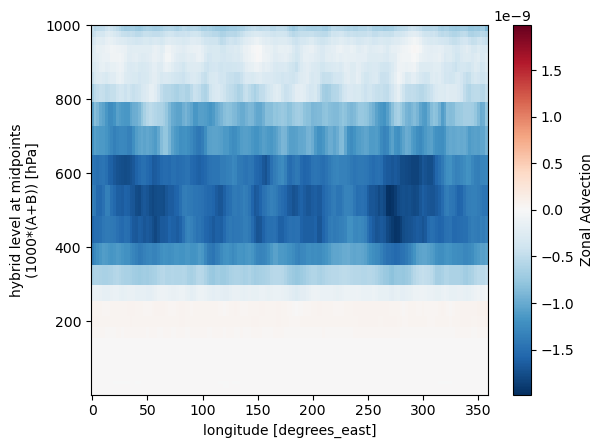

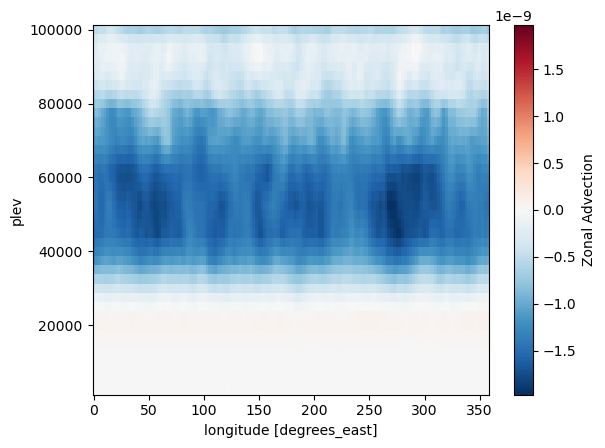

In [29]:
zonal_advection.sel(lat=slice(-15,15)).mean(dim=['time', 'lat']).plot()
plt.figure()
loaded_zonal_advection.sel(lat=slice(-15,15)).mean(dim=['time', 'lat']).plot()
# zonal_advection
# non_timed_data['PS']

In [32]:
loaded_zonal_advection['plev'] = loaded_zonal_advection.plev/100
loaded_zonal_advection.plev

<xarray.DataArray 'plev' (plev: 40)> Size: 320B
array([  25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,
        275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,  500.,
        525.,  550.,  575.,  600.,  625.,  650.,  675.,  700.,  725.,  750.,
        775.,  800.,  825.,  850.,  875.,  900.,  925.,  950.,  975., 1000.])
Coordinates:
  * plev     (plev) float64 320B 25.0 50.0 75.0 100.0 ... 950.0 975.0 1e+03

In [ ]:
# save_column_integrated_data = False

# # for experiment in ['4K', '0K', '-4K']:
# for experiment in ['4K']:
#     if experiment == '4K':
#         experiment_str = "4K_3h_10y"
#         experiment_storage = 'uwas0152'
#         experiment_shortname = '+4K'
#     elif experiment == '-4K':
#         experiment_str = "-4K_3h_10y"
#         experiment_storage = 'uwas0152'
#         experiment_shortname = '-4K'
#     elif experiment == '0K':
#         experiment_str = "3h_20y"
#         experiment_storage = 'uwas0114'
#         experiment_shortname = 'CTRL'
#     else:
#         raise ValueError(f"{experiment} is not a valid experiment type")

#     data_files = sorted(
#         glob.glob(
#             rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_{experiment_str}/atm/hist/*h1*.nc"
#         )
#     )

#     recalculate_budgets = True
#     n_files_to_load = 120
#     # n_files_to_load = 1
#     # n_files_to_load = len(data_files)

#     print(f"{'Calculate budget terms':^{str_width}}")
#     print(f"{f'Experiment: {experiment_shortname}':^{str_width}}")
#     print(f"{'='*str_width}")
#     if recalculate_budgets or 'multi_file_budget_variables' not in globals():
#         multi_file_budget_variables = []
#     multi_file_column_moisture = []
#     multi_file_surface_pressure = []
#     multi_file_precipitation = []
#     multi_file_outgoing_longwave_radiation = []
#     for index, file in enumerate(data_files[:n_files_to_load]):
#         data = xr.open_dataset(file).sel(lat=slice(-30,30))

#         meridional_mean_region = slice(-10,10)
#         weights = np.cos(np.deg2rad(data.lat))
#         weights.name = "weights"

#         if index == 0 or ((index+1) % (n_files_to_load//10))  == 0 or (index+1 == n_files_to_load):
#             print(f"({index+1}/{n_files_to_load}) {data.time.isel(time=0).values}")
#             # print(f"{'='*str_width}")

#         if recalculate_budgets:
#             interface_pressure_levels = (1/100)*data['P0']*data['hyai'] + (1/100)*data['PS']*data['hybi']
#             model_pressure_levels = (1/100)*data['P0']*data['hyam'] + (1/100)*data['PS']*data['hybm']
#             pressure_thickness = interface_pressure_levels.diff(dim='ilev')


#             moisture = data['Q']
#             moisture.name = 'Moisture'
#             moisture.attrs['units'] = 'kg/kg'

#             # print(f"{'MSE Tendency...':<{str_width-1}}", end="")
#             moisture_tendency = xr.zeros_like((moisture))
#             moisture_tendency[:] = np.gradient(moisture, 3*3600, axis=0)
#             # print(rf"{'✔':>1}")

#             # print(f"{'Zonal Advection...':<{str_width-1}}", end="")
#             zonal_moisture_gradient = xr.zeros_like((moisture))
#             zonal_moisture_gradient[:] = np.einsum(
#                 'k,ijkl->ijkl',
#                 1/(EARTH_RADIUS*np.cos(np.deg2rad(data.lat))),
#                 (180/np.pi)*moisture.differentiate('lon')
#             )

#             zonal_advection = xr.zeros_like((moisture))
#             zonal_advection[:] = -np.einsum(
#                 'ijkl, ijkl ->ijkl',
#                 data['U'],
#                 zonal_moisture_gradient
#             )


#             # print(rf"{'✔':>1}")

#             # print(f"{'Meridional Advection...':<{str_width-1}}", end="")
#             meridional_moisture_gradient = xr.zeros_like((moisture))
#             meridional_moisture_gradient[:] = 1/(EARTH_RADIUS)*(180/np.pi)*moisture.differentiate('lat')

#             meridional_advection = xr.zeros_like((moisture))
#             meridional_advection[:] = -np.einsum(
#                 'ijkl, ijkl ->ijkl',
#                 data['V'],
#                 meridional_moisture_gradient
#             )

#             # print(f"{'Vertical Advection...':<{str_width-1}}", end="")
#             # vertical_moisture_gradient = xr.zeros_like((moisture))
#             # for t_index, t_val in enumerate(data.time):
#             #     for lat_index, lat_val in enumerate(data.lat):
#             #         for lon_index, lon_val in enumerate(data.lon):
#             #             vertical_moisture_gradient[t_index, :, lat_index, lon_index] = np.gradient(
#             #                 moisture.isel(time=t_index, lat=lat_index, lon=lon_index),
#             #                 100*model_pressure_levels.isel(time=t_index, lat=lat_index, lon=lon_index)
#             #             )
#             vertical_moisture_gradient = (1/100)*moisture.differentiate('lev')

#             vertical_advection = xr.zeros_like((moisture))
#             vertical_advection[:] = -np.einsum(
#                 'ijkl, ijkl ->ijkl',
#                 data['OMEGA'],
#                 vertical_moisture_gradient
#             )
#             # print(rf"{'✔':>1}")

#             multi_level_variables = {
#                 'Moisture Tendency': moisture_tendency,
#                 'Zonal Advection': zonal_advection,
#                 'Meridional Advection': meridional_advection,
#                 'Vertical Advection': vertical_advection,
#             }

#             # Add in an interface level at 100 hPa as an upper bound
#             low_pressure_bound = 100
#             high_pressure_bound = interface_pressure_levels.where(
#                 interface_pressure_levels > low_pressure_bound
#             ).dropna('ilev').ilev[0]
#             interpolated_model_level_pressure = (
#                 high_pressure_bound + low_pressure_bound
#             ) / 2

#             concatenated_data = {}
#             concatenated_interface_pressure_levels = {}

#             for variable_name, variable_data in multi_level_variables.items():

#                 nearest_lev = model_pressure_levels.sel(
#                     lev=interpolated_model_level_pressure,
#                     method='nearest'
#                 ).lev
#                 if nearest_lev < interpolated_model_level_pressure:
#                     lower_interpolation_bound = nearest_lev
#                     upper_interpolation_bound = model_pressure_levels.lev.where(
#                         model_pressure_levels.lev > lower_interpolation_bound
#                     ).dropna(dim='lev').isel(lev=0)
#                 else:
#                     upper_interpolation_bound = nearest_lev
#                     lower_interpolation_bound = model_pressure_levels.lev.where(
#                         model_pressure_levels.lev < upper_interpolation_bound
#                     ).dropna(dim='lev').isel(lev=-1)

#                 interpolated_model_level_variable = xr.DataArray(
#                     data=np.empty(
#                         (
#                             len(variable_data.time),
#                             1,
#                             len(variable_data.lat),
#                             len(variable_data.lon)
#                         )
#                     ),
#                     dims=["time", "lev", "lat", "lon"],
#                     coords=dict(
#                         time=variable_data.time,
#                         lev=[interpolated_model_level_pressure],
#                         lat=variable_data.lat,
#                         lon=variable_data.lon,
#                     )
#                 )

#                 interpolated_model_level_variable[:] = (
#                     (
#                         (interpolated_model_level_pressure - lower_interpolation_bound)
#                         / (upper_interpolation_bound - lower_interpolation_bound)
#                     )
#                     * (
#                         variable_data.sel(lev=upper_interpolation_bound)
#                         - variable_data.sel(lev=lower_interpolation_bound)
#                     )
#                 ) + variable_data.sel(lev=lower_interpolation_bound)

#                 concatenated_data[variable_name] = xr.concat(
#                     [
#                         variable_data,
#                         interpolated_model_level_variable
#                     ],
#                     dim='lev'
#                 ).sortby('lev')
#                 concatenated_data[variable_name] = concatenated_data[variable_name].sel(
#                     lev=slice(
#                         interpolated_model_level_pressure,
#                         concatenated_data[variable_name].lev[-1]
#                     )
#                 )

#                 interpolated_interface_level_pressure = xr.DataArray(
#                     data=np.zeros(
#                         (
#                             len(variable_data.time),
#                             1,
#                             len(variable_data.lat),
#                             len(variable_data.lon)
#                         )
#                     ),
#                     dims=["time", "ilev", "lat", "lon"],
#                     coords=dict(
#                         time=variable_data.time,
#                         ilev=[low_pressure_bound],
#                         lat=variable_data.lat,
#                         lon=variable_data.lon,
#                     )
#                 )
#                 interpolated_interface_level_pressure[:] = 100
#                 concatenated_interface_pressure_levels[variable_name] = xr.concat(
#                     [interface_pressure_levels, interpolated_interface_level_pressure],
#                     dim='ilev'
#                 ).sortby('ilev')
#                 concatenated_interface_pressure_levels[variable_name] = concatenated_interface_pressure_levels[variable_name].sel(
#                     ilev=slice(low_pressure_bound, concatenated_interface_pressure_levels[variable_name].ilev[-1])
#                 )

#             # Column-integrations
#             column_moisture = column_integrate(
#                 concatenated_data['Moisture'],
#                 concatenated_interface_pressure_levels['Moisture'].diff('ilev')
#             )
#             column_moisture.name = 'Column Moisture'
#             column_moisture.attrs = {}
#             column_moisture.attrs['long_name'] = 'Column-integrated moisture'
#             column_moisture.attrs['math_name'] = r"$\langle$q$\rangle$"
#             column_moisture.attrs['units'] = r"kg m$^{-2}$"

#             test_concatenated_interface_pressure_levels = {}
#             test_concatenated_interface_pressure_levels['Moist Static Energy'] = concatenated_interface_pressure_levels['Moist Static Energy'].copy(deep=True)
#             test_concatenated_interface_pressure_levels['Moist Static Energy'][-1, :, :, :] = test_concatenated_interface_pressure_levels['Moist Static Energy'][-1, :, :, :].mean()
#             test_column_moisture = column_integrate(
#                 concatenated_data['Moist Static Energy'],
#                 test_concatenated_interface_pressure_levels['Moist Static Energy'].diff('ilev')
#             )
#             test_column_moisture.name = 'Test Moist Static Energy'

#             column_moisture = column_integrate(
#                 concatenated_data['Moist Static Energy'],
#                 concatenated_interface_pressure_levels['Moist Static Energy'].diff('ilev')
#             )
#             column_moisture.name = 'Moist Static Energy'
#             column_moisture.attrs = {}
#             column_moisture.attrs['long_name'] = 'Frozen Moist Static Energy'
#             column_moisture.attrs['math_name'] = r"$\langle$m$\rangle$"
#             column_moisture.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$$"

#             column_moisture_tendency = column_integrate(
#                 concatenated_data['MSE Tendency'],
#                 concatenated_interface_pressure_levels['MSE Tendency'].diff('ilev')
#             )
#             column_moisture_tendency.name = 'MSE Tendency'
#             column_moisture_tendency.attrs = {}
#             column_moisture_tendency.attrs['long_name'] = "Moist Static Energy Tendency"
#             column_moisture_tendency.attrs['math_name'] = r"$\langle$$\partial_{t}$m$\rangle$"
#             column_moisture_tendency.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$$"

#             column_zonal_advection = column_integrate(
#                 concatenated_data['Zonal Advection'],
#                 concatenated_interface_pressure_levels['Zonal Advection'].diff('ilev')
#             )
#             column_zonal_advection.name = 'Zonal Advection'
#             column_zonal_advection.attrs = {}
#             column_zonal_advection.attrs['long_name'] = "Zonal Advection of Moist Static Energy"
#             column_zonal_advection.attrs['math_name'] = r"$-\langle$$u \partial_{x}$m$\rangle$"
#             column_moisture_tendency.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$$"

#             column_meridional_advection = column_integrate(
#                 concatenated_data['Meridional Advection'],
#                 concatenated_interface_pressure_levels['Meridional Advection'].diff('ilev')
#             )
#             column_meridional_advection.name = 'Meridional Advection'
#             column_meridional_advection.attrs = {}
#             column_meridional_advection.attrs['long_name'] = "Meridional Advection of Moist Static Energy"
#             column_meridional_advection.attrs['math_name'] = r"$-\langle$$v \partial_{y}$m$\rangle$"
#             column_meridional_advection.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$$"

#             column_vertical_advection = column_integrate(
#                 concatenated_data['Vertical Advection'],
#                 concatenated_interface_pressure_levels['Vertical Advection'].diff('ilev')
#             )
#             column_vertical_advection.name = 'Vertical Advection'
#             column_vertical_advection.attrs = {}
#             column_vertical_advection.attrs['long_name'] = "Vertical Advection of Moist Static Energy"
#             column_vertical_advection.attrs['math_name'] = r"$-\langle$$ω \partial_{p}$m$\rangle$"
#             column_vertical_advection.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$$"

#             evaporation = data['LHFLX']/HEAT_OF_VAPORIZATION
#             evaporation.name = 'Evaporation'
#             evaporation.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$"
#             evaporation.attrs['short_name'] = r"E"

#             precipitation = (data['PRECC'] + data['PRECL'])*DENSITY_OF_WATER
#             precipitation.name = 'Precipitation'
#             precipitation.attrs['units'] = r"kg m$^{-2}$ s$^{-1}$"
#             precipitation.attrs['short_name'] = r"P"

#             estimated_column_moisture_tendency = (
#                 column_vertical_advection
#                 + column_zonal_advection
#                 + column_meridional_advection
#                 + evaporation
#                 - precipitation
#             )

#             column_residual = column_moisture_tendency - estimated_column_moisture_tendency
#             column_residual.name = 'Residual'
#             column_residual.attrs = {}
#             column_residual.attrs['long_name'] = r"Column-integrate MSE budget residual"
#             column_residual.attrs['math_name'] = r"Res."
#             column_residual.attrs['units'] = r"kg m$^{-2}$"

#             multi_file_budget_variables.append(
#                 xr.merge(
#                     [
#                         column_moisture,
#                         test_column_moisture,
#                         column_moisture_tendency,
#                         column_zonal_advection,
#                         column_meridional_advection,
#                         column_vertical_advection,
#                         column_longwave_heating,
#                         column_shortwave_heating,
#                         column_latent_heating,
#                         column_sensible_heating,
#                         column_residual,
#                     ]
#                 )
#             )
#         multi_file_column_moisture.append(column_moisture)
#         multi_file_surface_pressure.append(data['PS'])
#         multi_file_precipitation.append(
#             1000 * SECONDS_PER_DAY * (data['PRECC'] + data['PRECL'])
#         )
#         multi_file_outgoing_longwave_radiation.append(data['FLUT'])

#     print(f"{'='*str_width}")
#     print("Concatenating files together...")
#     column_moisture = xr.concat(multi_file_column_moisture, dim='time')
#     budget_variables = xr.concat(multi_file_budget_variables, dim="time")
#     surface_pressure = xr.concat(multi_file_surface_pressure, dim="time")
#     precipitation = xr.concat(multi_file_precipitation, dim="time")
#     precipitation.name = 'Precipitation'
#     precipitation.attrs['units'] = r"mm day$^{-1}$"
#     outgoing_longwave_radiation = xr.concat(multi_file_outgoing_longwave_radiation, dim="time")
#     outgoing_longwave_radiation.name = 'Outgoing Longwave Radiation'
#     outgoing_longwave_radiation.attrs['units'] = r"W m$^{-2}$"
#     print("Files concatenated")

#     if not save_column_integrated_data:
#         print("Budget variables not being saved")
#     else:
#         print("Saving budget variables to file...")
#         column_moisture.to_netcdf(rf"/glade/u/home/sressel/spencer-scratch/{experiment}/moisture_budget_analysis/{experiment}_column_moisture.nc")
#         budget_variables.to_netcdf(rf"/glade/u/home/sressel/spencer-scratch/{experiment}/moisture_budget_analysis/{experiment}_budget_variables.nc")
#         print("Budget variables saved")

# print(f"{'='*str_width}")
# print("Finished")

## Daily pressure-level data

In [ ]:
xr.set_options(keep_attrs=True)
recalculate = False
print(f"{f'Budget Terms':^{str_width}}")
print(f"{'='*str_width}")
print(f"{f'Recalculating: {recalculate}':^{str_width}}")
print(f"{'='*str_width}")

n_calculations = 9

latitude = multi_experiment_variables_subset['Moisture'].lat
longitude = multi_experiment_variables_subset['Moisture'].lon

meridional_mean_region = slice(-10,10)
weights = np.cos(np.deg2rad(latitude))
weights.name = "weights"

# Calculate x and y distance grids
EARTH_RADIUS = 6.3781e6
zonal_distance = EARTH_RADIUS*np.einsum(
    'i,j->ij',
    np.cos(np.deg2rad(latitude.values)),
    np.deg2rad(longitude.values)
)
meridional_distance = EARTH_RADIUS*np.deg2rad(latitude.values)

# # Column moisture
print(f"{f'(1/{n_calculations}) Column moisture...':<{str_width-1}}", end="")
if recalculate or 'column_moisture' not in globals():
    column_moisture = (100/9.81)*multi_experiment_variables_subset['Moisture'].sel(plev=pressure_subset_bounds).integrate('plev')
column_moisture.attrs['short_name'] = r"$\langle q \rangle$"
column_moisture.name = 'Column Moisture'
meridional_mean_column_moisture = column_moisture.sel(
    lat=meridional_mean_region
).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# Column moisture tendency
print(f"{f'(2/{n_calculations}) Column Moisture tendency...':<{str_width-1}}", end="")
if recalculate or 'column_moisture_tendency' not in globals():
    column_moisture_tendency = xr.zeros_like((column_moisture))
    column_moisture_tendency[:] = np.gradient(column_moisture, 24*3600, axis=1)
column_moisture_tendency.attrs['short_name'] = r"$\langle \partial_{t}q \rangle$"
column_moisture_tendency.name = 'Column Moisture Tendency'
meridional_mean_column_moisture_tendency = column_moisture_tendency.sel(
    lat=meridional_mean_region
).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# Calculate moisture gradients
print(f"{f'(3/{n_calculations}) Moisture gradients...':<{str_width-1}}")

if recalculate or 'zonal_moisture_gradient' not in globals():
    print(f"{'    (1/3) Zonal moisture gradient...':<{str_width-1}}", end="")
    # zonal_moisture_gradient = (
    #     1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude)))
    #     *(180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lon')
    # )
    zonal_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    zonal_moisture_gradient[:] = np.einsum(
        'k,ijklm->ijklm',
        1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude))),
        (180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lon')
    )
    print(rf"{'✔':>1}")

if recalculate or 'meridional_moisture_gradient' not in globals():
    print(f"{'    (2/3) Meridional moisture gradient...':<{str_width-1}}", end="")
    meridional_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    meridional_moisture_gradient[:] = (
        (1/EARTH_RADIUS)
        *(180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lat')
    )
    print(rf"{'✔':>1}")

if recalculate or 'vertical_moisture_gradient' not in globals():
    print(f"{'    (3/3) Vertical moisture gradient...':<{str_width-1}}", end="")
    vertical_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    vertical_moisture_gradient[:] = (
        (1/100)*multi_experiment_variables_subset['Moisture'].differentiate(coord='plev')
    )
    print(rf"{'✔':>1}")

# Zonal advection
print(f"{f'(4/{n_calculations}) Zonal advection...':<{str_width-1}}", end="")
if recalculate or 'zonal_advection' not in globals():
    # zonal_advection = multi_experiment_variables_subset['Zonal Wind']*zonal_moisture_gradient
    zonal_advection = xr.zeros_like((multi_experiment_variables_subset['Zonal Wind']))
    zonal_advection[:] = np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Zonal Wind'],
        zonal_moisture_gradient
    )
    column_zonal_advection = -(100/9.8)*zonal_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
column_zonal_advection.name = 'Column Zonal Advection'
column_zonal_advection.attrs['short_name'] = r"-$\langle u \partial_{x}q \rangle$"
meridional_mean_column_zonal_advection = column_zonal_advection.sel(
    lat=meridional_mean_region
).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# Meridional advection
print(f"{f'(5/{n_calculations}) Meridional advection...':<{str_width-1}}", end="")
if recalculate or 'meridional_advection' not in globals():
    # meridional_advection = multi_experiment_variables_subset['Meridional Wind']*meridional_moisture_gradient
    meridional_advection = xr.zeros_like((multi_experiment_variables_subset['Meridional Wind']))
    meridional_advection[:] = np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Meridional Wind'],
        meridional_moisture_gradient
    )
    column_meridional_advection = -(100/9.8)*meridional_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
column_meridional_advection.name = 'Column Meridional Advection'
column_meridional_advection.attrs['short_name'] = r"-$\langle v \partial_{y}q \rangle$"
meridional_mean_column_meridional_advection = column_meridional_advection.sel(
    lat=meridional_mean_region
).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# Vertical advection
print(f"{f'(6/{n_calculations}) Vertical advection...':<{str_width-1}}", end="")
if recalculate or 'vertical_advection' not in globals():
    # vertical_advection = multi_experiment_variables_subset['Vertical Wind']*vertical_moisture_gradient
    vertical_advection = xr.zeros_like((multi_experiment_variables_subset['Vertical Wind']))
    vertical_advection[:] = np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Vertical Wind'],
        vertical_moisture_gradient
    )
    column_vertical_advection = -(100/9.8)*vertical_advection.sel(plev=pressure_subset_bounds).integrate('plev')

column_vertical_advection.name = 'Column Vertical Advection'
column_vertical_advection.attrs['short_name'] = r"-$\langle \omega \partial_{p}q \rangle$"
meridional_mean_column_vertical_advection = column_vertical_advection.sel(
    lat=meridional_mean_region
).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# Other terms
print(f"{f'(7/{n_calculations}) Evaporation...':<{str_width-1}}", end="")
if recalculate or 'budget_evaporation' not in globals():
    budget_evaporation = (1/HEAT_OF_VAPORIZATION)*multi_experiment_variables_subset['Latent Heat Flux']

budget_evaporation.name = 'Evaporation'
budget_evaporation.attrs['short_name'] = r"$E$"
meridional_mean_evaporation = budget_evaporation.sel(
        lat=meridional_mean_region
    ).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

print(f"{f'(8/{n_calculations}) Precipitation...':<{str_width-1}}", end="")
if recalculate or 'budget_precipitation' not in globals():
    budget_precipitation = -multi_experiment_variables_subset['Precipitation']/SECONDS_PER_DAY
budget_precipitation.name = 'Precipitation'
budget_precipitation.attrs['short_name'] = r"-$P$"
meridional_mean_precipitation = budget_precipitation.sel(
        lat=meridional_mean_region
    ).weighted(weights).mean(dim='lat')
print(rf"{'✔':>1}")

# print(f"{f'(9/{n_calculations}) Residual...':<{str_width-1}}", end="")
# if recalculate or 'meridional_mean_residual' not in globals():
#     meridional_mean_residual = meridional_mean_column_moisture_tendency - (
#         + meridional_mean_column_vertical_advection
#         + meridional_mean_column_zonal_advection
#         + meridional_mean_column_meridional_advection
#         + meridional_mean_evaporation
#         + meridional_mean_precipitation
#     )
#     meridional_mean_residual.name = 'Residual'
#     meridional_mean_residual.attrs['short_name'] = 'Res.'
# print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

In [47]:
output_directory = "/glade/derecho/scratch/sressel/"
recalculate = True
save_data = True

print(f"{f'Moisture Budget Calculation':^{str_width}}")
print(f"{'='*str_width}")

# Initialize arrays for budget variables
column_moisture = {}
column_moisture_tendency = {}
column_zonal_advection = {}
column_meridional_advection = {}
column_vertical_advection = {}
evaporation = {}
precipitation = {}
column_residual = {}

n_calculations = 9
experiments_list = ['-4K', '0K', '4K']

variables_subset = {}
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variables_subset_files = sorted(glob.glob(
        rf"/glade/derecho/scratch/sressel/{experiment}/variables_subset/*.nc"
    ))
    for index, file in enumerate(variables_subset_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variables_subset_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_subset[variable_data.name] = variable_data
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    print(f"{f'Calculating Moisture Budget Terms...':<{str_width}}")
    print(f"{'-'*str_width}")
    latitude = variables_subset['Moisture'].lat
    longitude = variables_subset['Moisture'].lon
    pressure_levels = variables_subset['Moisture'].plev
    time = variables_subset['Moisture'].time

    meridional_mean_region = slice(-10,10)
    weights = np.cos(np.deg2rad(latitude))
    weights.name = "weights"

    # Calculate x and y distance grids
    EARTH_RADIUS = 6.3781e6
    zonal_distance = EARTH_RADIUS*np.einsum(
        'i,j->ij',
        np.cos(np.deg2rad(latitude.values)),
        np.deg2rad(longitude.values)
    )
    meridional_distance = EARTH_RADIUS*np.deg2rad(latitude.values)

    # # Column moisture
    print(f"{f'(1/{n_calculations}) Column moisture...':<{str_width-1}}", end="")
    if recalculate or 'column_moisture' not in globals():
        column_moisture[experiment] = (100/9.81)*variables_subset['Moisture'].sel(plev=pressure_subset_bounds).integrate('plev')
    column_moisture[experiment].attrs['short_name'] = r"$\langle q \rangle$"
    column_moisture[experiment].name = 'Column Moisture'
    print(rf"{'✔':>1}")

    # Column moisture tendency
    print(f"{f'(2/{n_calculations}) Column Moisture tendency...':<{str_width-1}}", end="")
    if recalculate or 'column_moisture_tendency' not in globals():
        column_moisture_tendency[experiment] = xr.zeros_like((column_moisture[experiment]))
        column_moisture_tendency[experiment][:] = np.gradient(column_moisture[experiment], 24*3600, axis=1)
    column_moisture_tendency[experiment].attrs['short_name'] = r"$\langle \partial_{t}q \rangle$"
    column_moisture_tendency[experiment].name = 'Column Moisture Tendency'
    print(rf"{'✔':>1}")

    # Calculate moisture gradients
    print(f"{f'(3/{n_calculations}) Moisture gradients...':<{str_width-1}}")

    if recalculate or 'zonal_moisture_gradient' not in globals():
        print(f"{'    (1/3) Zonal moisture gradient...':<{str_width-1}}", end="")
        # zonal_moisture_gradient = (
        #     1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude)))
        #     *(180/np.pi)*variables_subset['Moisture'].differentiate('lon')
        # )
        zonal_moisture_gradient = xr.zeros_like((variables_subset['Moisture']))
        zonal_moisture_gradient[:] = np.einsum(
            'j,ijkl->ijkl',
            1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude))),
            (180/np.pi)*variables_subset['Moisture'].differentiate('lon')
        )
        print(rf"{'✔':>1}")

    if recalculate or 'meridional_moisture_gradient' not in globals():
        print(f"{'    (2/3) Meridional moisture gradient...':<{str_width-1}}", end="")
        meridional_moisture_gradient = xr.zeros_like((variables_subset['Moisture']))
        meridional_moisture_gradient[:] = (
            (1/EARTH_RADIUS)
            *(180/np.pi)*variables_subset['Moisture'].differentiate('lat')
        )
        print(rf"{'✔':>1}")

    if recalculate or 'vertical_moisture_gradient' not in globals():
        print(f"{'    (3/3) Vertical moisture gradient...':<{str_width-1}}", end="")
        vertical_moisture_gradient = xr.zeros_like((variables_subset['Moisture']))
        vertical_moisture_gradient[:] = (
            (1/100)*variables_subset['Moisture'].differentiate(coord='plev')
        )
        print(rf"{'✔':>1}")

    # Zonal advection
    print(f"{f'(4/{n_calculations}) Zonal advection...':<{str_width-1}}", end="")
    if recalculate or 'zonal_advection' not in globals():
        # zonal_advection = variables_subset['Zonal Wind']*zonal_moisture_gradient
        zonal_advection = xr.zeros_like((variables_subset['Zonal Wind']))
        zonal_advection[:] = np.einsum(
            'ijkl, ijkl ->ijkl',
            variables_subset['Zonal Wind'],
            zonal_moisture_gradient
        )
        column_zonal_advection[experiment] = -(100/9.8)*zonal_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
    column_zonal_advection[experiment].name = 'Column Zonal Advection'
    column_zonal_advection[experiment].attrs['short_name'] = r"-$\langle u \partial_{x}q \rangle$"
    print(rf"{'✔':>1}")

    # Meridional advection
    print(f"{f'(5/{n_calculations}) Meridional advection...':<{str_width-1}}", end="")
    if recalculate or 'meridional_advection' not in globals():
        # meridional_advection = variables_subset['Meridional Wind']*meridional_moisture_gradient
        meridional_advection = xr.zeros_like((variables_subset['Meridional Wind']))
        meridional_advection[:] = np.einsum(
            'ijkl, ijkl ->ijkl',
            variables_subset['Meridional Wind'],
            meridional_moisture_gradient
        )
        column_meridional_advection[experiment] = -(100/9.8)*meridional_advection.sel(plev=pressure_subset_bounds).integrate(coord='plev')
    column_meridional_advection[experiment].name = 'Column Meridional Advection'
    column_meridional_advection[experiment].attrs['short_name'] = r"-$\langle v \partial_{y}q \rangle$"
    print(rf"{'✔':>1}")

    # Vertical advection
    print(f"{f'(6/{n_calculations}) Vertical advection...':<{str_width-1}}", end="")
    if recalculate or 'vertical_advection' not in globals():
        # vertical_advection = variables_subset['Vertical Wind']*vertical_moisture_gradient
        vertical_advection = xr.zeros_like((variables_subset['Vertical Wind']))
        vertical_advection[:] = np.einsum(
            'ijkl, ijkl ->ijkl',
            variables_subset['Vertical Wind'],
            vertical_moisture_gradient
        )
        column_vertical_advection[experiment] = -(100/9.8)*vertical_advection.sel(plev=pressure_subset_bounds).integrate('plev')

    column_vertical_advection[experiment].name = 'Column Vertical Advection'
    column_vertical_advection[experiment].attrs['short_name'] = r"-$\langle \omega \partial_{p}q \rangle$"
    print(rf"{'✔':>1}")

    # Other terms
    print(f"{f'(7/{n_calculations}) Evaporation...':<{str_width-1}}", end="")
    if recalculate or 'evaporation' not in globals():
        evaporation[experiment] = (1/HEAT_OF_VAPORIZATION)*variables_subset['Latent Heat Flux']

    evaporation[experiment].name = 'Evaporation'
    evaporation[experiment].attrs['short_name'] = r"$E$"
    print(rf"{'✔':>1}")

    print(f"{f'(8/{n_calculations}) Precipitation...':<{str_width-1}}", end="")
    if recalculate or 'precipitation' not in globals():
        precipitation[experiment] = -variables_subset['Precipitation']/SECONDS_PER_DAY
    precipitation[experiment].name = 'Precipitation'
    precipitation[experiment].attrs['short_name'] = r"-$P$"
    print(rf"{'✔':>1}")


    print(f"{f'(11/{n_calculations}) Residual...':<{str_width-1}}", end="")
    column_moisture_tendency_estimate = (
        column_zonal_advection[experiment]
        + column_meridional_advection[experiment]
        + column_vertical_advection[experiment]
        + evaporation[experiment]
        + precipitation[experiment]
    )

    column_residual[experiment] = column_moisture_tendency[experiment] - column_moisture_tendency_estimate
    column_residual[experiment].name = 'Residual'
    column_residual[experiment].attrs['short_name'] = 'Res.'
    print(rf"{'✔':>1}")
print(f"{'='*str_width}")

moisture_budget_variables = {
    'Moisture': column_moisture,
    'Moisture Tendency': column_moisture_tendency,
    'Zonal Advection': column_zonal_advection,
    'Meridional Advection': column_meridional_advection,
    'Vertical Advection': column_vertical_advection,
    'Evaporation': evaporation,
    'Precipitation': precipitation,
    'Residual': column_residual
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(moisture_budget_variables):
    print(f"{f'({index+1}/{len(moisture_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [moisture_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    print(rf"{'✔':>1}")

if save_data:
    print(f"{'='*str_width}")
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{output_directory}/moisture_budget_terms/daily_pressure-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

      moisture Budget Calculation       
----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/18) Column Longwave Heating...      ✔
(2/18) Column MSE...                   ✔
(3/18) Column Shortwave Heating...     ✔
(4/18) Column Temperature...           ✔
(5/18) Column Water Vapor...           ✔
(6/18) Geopotential Height...          ✔
(7/18) Latent Heat Flux...             ✔
(8/18) Longwave Heating Rate...        ✔
(9/18) Meridional Wind...              ✔
(10/18) Moist Static Energy...         ✔
(11/18) Moisture...                    ✔
(12/18) Outgoing Longwave Radiation... ✔
(13/18) Precipitation...               ✔
(14/18) Sensible Heat Flux...          ✔
(15/18) Shortwave Heating Rate...      ✔
(16/18) Temperature...                 ✔
(17/18) Vertical Wind...               ✔
(18/18) Zonal Wind...                  ✔
----------------------------------------
Calculating Moisture Budget Terms...    
----------------

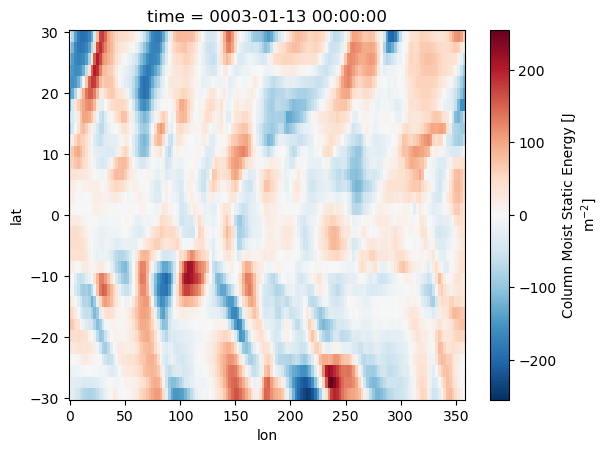

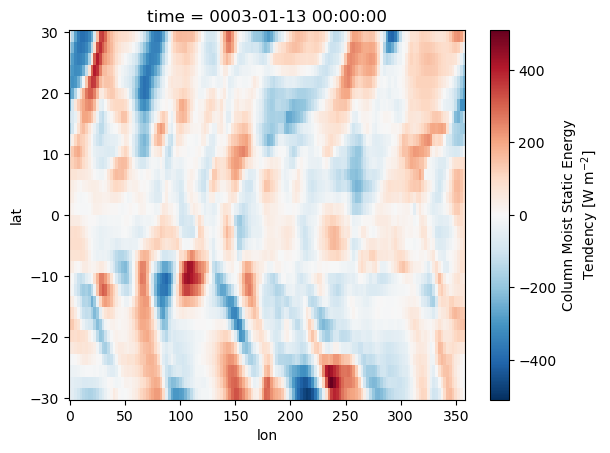

In [46]:
test_dMSEdt.isel(time=10).plot()
plt.figure()
column_MSE_tendency['4K'].isel(time=10).plot()

In [48]:
if save_data:
    print(f"{'='*str_width}")
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{output_directory}/moisture_budget_terms/daily_pressure-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

          Saving budget terms           
(1/8) Moisture...                      ✔
(2/8) Moisture Tendency...             ✔
(3/8) Zonal Advection...               ✔
(4/8) Meridional Advection...          ✔
(5/8) Vertical Advection...            ✔
(6/8) Evaporation...                   ✔
(7/8) Precipitation...                 ✔
(8/8) Residual...                      ✔
Finished


# Mid-level Moisture

In [4]:
print(f"{f'Loading subset data':^{str_width}}")

experiments_list = ['-4K', '0K', '4K']
experiments_array = xr.DataArray(
    data=experiments_list,
    dims=["experiment"],
    coords={'experiment': experiments_list}
)

variables_to_load = [
    'Moisture',
    'Zonal Wind',
    'Meridional Wind',
    'Vertical Wind'
]

variable_data_by_experiment = {}
multi_experiment_variables_subset = {}

for index, variable_name in enumerate(variables_to_load):
    # Print the variable name
    print(f"{'='*str_width}")
    print(f"{f'({index+1}/{len(variables_to_load)}) {variable_name}...':<{str_width}}")
    print(f"{'-'*str_width}")

    # Initialize a list to hold the experiment data for this variable
    variable_data_by_experiment[variable_name] = []

    # For each variable, loop over the experiments and find/load the data
    print("Loading data...")
    for experiment in experiments_list:
        print(f"{f'    Experiment: {experiment}':<{str_width-1}}", end="")
        file_location = rf"/glade/derecho/scratch/sressel/{experiment}/variables_subset"
        subset_files = glob.glob(f"{file_location}/{variable_name.lower().replace(' ', '_')}.nc"
    )

        # Does the variable have data?
        if subset_files:
            # Append it to the list
            for index, file in enumerate(subset_files):
                variable_data_by_experiment[variable_name].append(xr.open_dataarray(file))
            print(rf"{'✔':>1}")

        else:
            # Move on to the next variable
            print(rf"{'✘':>1}")
            print(f"    No data")

    # For each variable with data, concatenate the experiments into a single DataArray
    if variable_data_by_experiment[variable_name]:
        print(f"{'Concatenating data...':<{str_width-1}}", end="")
        multi_experiment_variables_subset[variable_name] = xr.concat(
                    variable_data_by_experiment[variable_name],
                    dim=experiments_array
        )
        print(rf"{'✔':>1}")
    else:
        pass

print(f"{'='*str_width}")
print("Finished")

          Loading subset data           
(1/4) Moisture...                       
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(2/4) Zonal Wind...                     
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(3/4) Meridional Wind...                
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/4) Vertical Wind...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                

In [5]:
xr.set_options(keep_attrs=True)
recalculate = True
print(f"{f'Budget Terms':^{str_width}}")
print(f"{'='*str_width}")
print(f"{f'Recalculating: {recalculate}':^{str_width}}")
print(f"{'='*str_width}")

n_calculations = 6

time = multi_experiment_variables_subset['Moisture'].time
pressure_levels = multi_experiment_variables_subset['Moisture'].plev
latitude = multi_experiment_variables_subset['Moisture'].lat
longitude = multi_experiment_variables_subset['Moisture'].lon


meridional_mean_region = slice(-10,10)
weights = np.cos(np.deg2rad(latitude))
weights.name = "weights"

# Calculate x and y distance grids
EARTH_RADIUS = 6.3781e6
zonal_distance = EARTH_RADIUS*np.einsum(
    'i,j->ij',
    np.cos(np.deg2rad(latitude.values)),
    np.deg2rad(longitude.values)
)
meridional_distance = EARTH_RADIUS*np.deg2rad(latitude.values)

# moisture tendency
print(f"{f'(1/{n_calculations}) Moisture Tendency...':<{str_width-1}}", end="")
if recalculate or 'moisture_tendency' not in globals():
    moisture_tendency = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    moisture_tendency[:] = np.gradient(multi_experiment_variables_subset['Moisture'], 24*3600, axis=1)
moisture_tendency.attrs['short_name'] = r"$\partial_{t}q$"
moisture_tendency.name = 'Moisture Tendency'
print(rf"{'✔':>1}")

# Calculate moisture gradients
print(f"{f'(2/{n_calculations}) Moisture gradients...':<{str_width-1}}")

if recalculate or 'zonal_moisture_gradient' not in globals():
    print(f"{'    (1/3) Zonal moisture gradient...':<{str_width-1}}", end="")
    # zonal_moisture_gradient = (
    #     1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude)))
    #     *(180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lon')
    # )
    zonal_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    zonal_moisture_gradient[:] = np.einsum(
        'k,ijklm->ijklm',
        1/(EARTH_RADIUS*np.cos(np.deg2rad(latitude))),
        (180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lon')
    )
    print(rf"{'✔':>1}")

if recalculate or 'meridional_moisture_gradient' not in globals():
    print(f"{'    (2/3) Meridional moisture gradient...':<{str_width-1}}", end="")
    meridional_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    meridional_moisture_gradient[:] = (
        (1/EARTH_RADIUS)
        *(180/np.pi)*multi_experiment_variables_subset['Moisture'].differentiate('lat')
    )
    print(rf"{'✔':>1}")

if recalculate or 'vertical_moisture_gradient' not in globals():
    print(f"{'    (3/3) Vertical moisture gradient...':<{str_width-1}}", end="")
    vertical_moisture_gradient = xr.zeros_like((multi_experiment_variables_subset['Moisture']))
    vertical_moisture_gradient[:] = (
        (1/100)*multi_experiment_variables_subset['Moisture'].differentiate(coord='plev')
    )
    print(rf"{'✔':>1}")

# Zonal advection
print(f"{f'(3/{n_calculations}) Zonal advection...':<{str_width-1}}", end="")
if recalculate or 'zonal_advection' not in globals():
    # zonal_advection = multi_experiment_variables_subset['Zonal Wind']*zonal_moisture_gradient
    zonal_advection = xr.zeros_like((multi_experiment_variables_subset['Zonal Wind']))
    zonal_advection[:] = -np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Zonal Wind'],
        zonal_moisture_gradient
    )
zonal_advection.name = 'Zonal Advection'
zonal_advection.attrs['short_name'] = r"-$ u \partial_{x}q $"

print(rf"{'✔':>1}")

# Meridional advection
print(f"{f'(4/{n_calculations}) Meridional advection...':<{str_width-1}}", end="")
if recalculate or 'meridional_advection' not in globals():
    # meridional_advection = multi_experiment_variables_subset['Meridional Wind']*meridional_moisture_gradient
    meridional_advection = xr.zeros_like((multi_experiment_variables_subset['Meridional Wind']))
    meridional_advection[:] = -np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Meridional Wind'],
        meridional_moisture_gradient
    )
meridional_advection.name = 'Meridional Advection'
meridional_advection.attrs['short_name'] = r"-$\langle v \partial_{y}q \rangle$"
print(rf"{'✔':>1}")

# Vertical advection
print(f"{f'(5/{n_calculations}) Vertical advection...':<{str_width-1}}", end="")
if recalculate or 'vertical_advection' not in globals():
    # vertical_advection = multi_experiment_variables_subset['Vertical Wind']*vertical_moisture_gradient
    vertical_advection = xr.zeros_like((multi_experiment_variables_subset['Vertical Wind']))
    vertical_advection[:] = -np.einsum(
        'ijklm, ijklm ->ijklm',
        multi_experiment_variables_subset['Vertical Wind'],
        vertical_moisture_gradient
    )

vertical_advection.name = 'Vertical Advection'
vertical_advection.attrs['short_name'] = r"-$\omega \partial_{p}q $"
print(rf"{'✔':>1}")

print(f"{f'(6/{n_calculations}) Apparent Moisture Source...':<{str_width-1}}", end="")
if recalculate or 'apparent_moisture_source' not in globals():
    apparent_moisture_source = (
        moisture_tendency
        - zonal_advection
        - meridional_advection
        - vertical_advection
    )
apparent_moisture_source.name = 'Apparent Moisture Source'
apparent_moisture_source.attrs['short_name'] = r"-Q$_2$"
print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

              Budget Terms              
          Recalculating: True           
(1/6) Moisture Tendency...             ✔
(2/6) Moisture gradients...            
    (1/3) Zonal moisture gradient...   ✔
    (2/3) Meridional moisture gradient...✔
    (3/3) Vertical moisture gradient...✔
(3/6) Zonal advection...               ✔
(4/6) Meridional advection...          ✔
(5/6) Vertical advection...            ✔
(6/6) Apparent Moisture Source...      ✔
Finished


# Advection Term Breakdowns

## Zonal Moisture Advection

In [4]:
recalculate_budgets = True
save_column_integrated_data = True

variables_loaded = {}

column_mean_wind_mean_moisture = {}
column_mean_wind_mjo_moisture = {}
column_mean_wind_residual_moisture = {}
column_mjo_wind_mean_moisture = {}
column_mjo_wind_mjo_moisture = {}
column_mjo_wind_residual_moisture = {}
column_residual_wind_mean_moisture = {}
column_residual_wind_mjo_moisture = {}
column_residual_wind_residual_moisture = {}

for experiment in ['-4K', '0K', '4K']:
# for experiment in ['0K']:

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
            rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
        ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME)).drop_sel(time=missing_days, errors='ignore')
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    non_timed_data =  xr.open_dataset(
            rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/"
            + f"SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
        )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")
        lower_level_pressure = 1100.*100.
        # upper_level_pressure = 100.*100.
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
        temperature_minimum_index = time_mean_temperature.argmin('lev')
        temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
        upper_level_pressure = temperature_minimum_pressure_level.values

    # print(f"{'MJO Filter OLR...':<{str_width-1}}", end="")
    # first_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=first_half_subset_bounds), slice(100, 20))
    # second_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=second_half_subset_bounds), slice(100, 20))
    # first_half_mjo_olr = mjo_filter_data(first_half_intraseasonal_olr, slice(1, 3))
    # second_half_mjo_olr = mjo_filter_data(second_half_intraseasonal_olr, slice(1, 3))
    # mjo_filtered_olr = xr.concat((first_half_mjo_olr, second_half_mjo_olr), dim='time')
    # print(rf"{'✔':>1}")

    print(f"{'Calculate dQ/dx...':<{str_width-1}}", end="")
    zonal_moisture_gradient = (
            (180/np.pi)
            * variables_loaded['Q'].differentiate('lon')
            / (EARTH_RADIUS*np.cos(np.deg2rad(variables_loaded['Q'].lat)))
        )
    zonal_moisture_gradient.name = 'Zonal Moisture Gradient'
    print(rf"{'✔':>1}")

    variables_loaded['U'].name = 'Zonal Wind'

    time_mean_component = {}
    mjo_component = {}
    residual_component = {}

    print(f"{'Calculate components':<{str_width-1}}")
    for variable in [
        variables_loaded['U'],
        zonal_moisture_gradient
    ]:
        print(f"{f'{variable.name}':<{str_width}}")
        print(f"{'-'*str_width}")
        print(f"{'  Time Mean...':<{str_width-1}}", end="")
        time_mean_component[variable.name] = variable.mean(dim='time')
        print(rf"{'✔':>1}")

        # print(f"{'  MJO-Correlated...':<{str_width-1}}", end="")
        # standardized_variable = standardize_data(variable)

        # correlation_coefficients = xr.dot(
        #     standardized_variable,
        #     standardize_data(mjo_filtered_olr),
        #     dim='time'
        # ) / len(mjo_filtered_olr.time)

        # mjo_component[variable.name] = correlation_coefficients * variable
        # print(rf"{'✔':>1}")
        print(f"{'  MJO...':<{str_width-1}}", end="")
        first_half_intraseasonal_data = time_filter_data(variable.sel(time=first_half_subset_bounds), slice(100, 20))
        second_half_intraseasonal_data = time_filter_data(variable.sel(time=second_half_subset_bounds), slice(100, 20))
        mjo_component[variable.name] = xr.concat((first_half_intraseasonal_data, second_half_intraseasonal_data), dim='time')
        print(rf"{'✔':>1}")

        print(f"{'  Residual...':<{str_width-1}}", end="")
        residual_component[variable.name] = (
            variable
            - time_mean_component[variable.name]
            - mjo_component[variable.name]
        )
        print(rf"{'✔':>1}")
        print(f"{'-'*str_width}")

    print(f"{'Column integrate...':<{str_width-1}}", end="")
    column_mean_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Zonal Wind']*time_mean_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mean_moisture[experiment].name = 'Mean wind mean moisture'
    column_mean_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mean_moisture[experiment].attrs['math_name'] = r"-$\bar{u} \partial_x \bar{q}$"

    column_mean_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Zonal Wind']*mjo_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mjo_moisture[experiment].name = 'Mean wind MJO moisture'
    column_mean_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$\bar{u} \partial_x q_{MJO}$"

    column_mean_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Zonal Wind']*residual_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_residual_moisture[experiment].name = 'Mean wind residial moisture'
    column_mean_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_residual_moisture[experiment].attrs['math_name'] = r"-$\bar{u} \partial_x q_{res}$"

    column_mjo_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Zonal Wind']*time_mean_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mean_moisture[experiment].name = 'MJO wind mean moisture'
    column_mjo_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mean_moisture[experiment].attrs['math_name'] = r"-$u_{MJO} \partial_x \bar{q}$"

    column_mjo_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Zonal Wind']*mjo_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mjo_moisture[experiment].name = 'MJO wind MJO moisture'
    column_mjo_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$u_{MJO} \partial_x q_{MJO}$"

    column_mjo_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Zonal Wind']*residual_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_residual_moisture[experiment].name = 'MJO wind residual moisture'
    column_mjo_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$u_{MJO} \partial_x q_{res}$"

    column_residual_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Zonal Wind']*time_mean_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mean_moisture[experiment].name = 'Residual wind mean moisture'
    column_residual_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mean_moisture[experiment].attrs['math_name'] = r"-$u_{res} \partial_x \bar{q}$"

    column_residual_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Zonal Wind']*mjo_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mjo_moisture[experiment].name = 'Residual wind MJO moisture'
    column_residual_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mjo_moisture[experiment].attrs['math_name'] =  r"-$u_{res} \partial_x q_{MJO}$"

    column_residual_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Zonal Wind']*residual_component['Zonal Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_residual_moisture[experiment].name = 'Residual wind residual moisture'
    column_residual_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$u_{res} \partial_x q_{res}$"
    print(rf"{'✔':>1}")

moisture_budget_variables = {
    'Zonal Advection Mean wind mean moisture': column_mean_wind_mean_moisture,
    'Zonal Advection Mean wind MJO moisture': column_mean_wind_mjo_moisture,
    'Zonal Advection Mean wind residial moisture': column_mean_wind_residual_moisture,
    'Zonal Advection MJO wind mean moisture': column_mjo_wind_mean_moisture,
    'Zonal Advection MJO wind MJO moisture': column_mjo_wind_mjo_moisture,
    'Zonal Advection MJO wind residual moisture': column_mjo_wind_residual_moisture,
    'Zonal Advection Residual wind mean moisture': column_residual_wind_mean_moisture,
    'Zonal Advection Residual wind MJO moisture': column_residual_wind_mjo_moisture,
    'Zonal Advection Residual wind residual moisture': column_residual_wind_residual_moisture,
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(moisture_budget_variables):
    print(f"{f'({index+1}/{len(moisture_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [moisture_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    multi_experiment_budget_variables[budget_variable].attrs = moisture_budget_variables[budget_variable]['0K'].attrs
    print(rf"{'✔':>1}")

if save_column_integrated_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/moisture_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            # response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            response = 'y'
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
Calculate dQ/dx...                     ✔
Calculate components                   
Zonal Wind       

## Meridional Moisture Advection

In [5]:
recalculate_budgets = True
save_column_integrated_data = True

variables_loaded = {}

column_mean_wind_mean_moisture = {}
column_mean_wind_mjo_moisture = {}
column_mean_wind_residual_moisture = {}
column_mjo_wind_mean_moisture = {}
column_mjo_wind_mjo_moisture = {}
column_mjo_wind_residual_moisture = {}
column_residual_wind_mean_moisture = {}
column_residual_wind_mjo_moisture = {}
column_residual_wind_residual_moisture = {}

for experiment in ['-4K', '0K', '4K']:
# for experiment in ['0K']:

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
            rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
        ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME)).drop_sel(time=missing_days, errors='ignore')
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    non_timed_data =  xr.open_dataset(
            rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/"
            + f"SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
        )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")
        lower_level_pressure = 1100.*100.
        # upper_level_pressure = 100.*100.
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
        temperature_minimum_index = time_mean_temperature.argmin('lev')
        temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
        upper_level_pressure = temperature_minimum_pressure_level.values

    print(f"{'MJO Filter OLR...':<{str_width-1}}", end="")
    first_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=first_half_subset_bounds), slice(100, 20))
    second_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=second_half_subset_bounds), slice(100, 20))
    # time_filtered_olr = xr.concat((first_half_time_olr, second_half_time_olr), dim='time')
    first_half_mjo_olr = mjo_filter_data(first_half_intraseasonal_olr, slice(1, 3))
    second_half_mjo_olr = mjo_filter_data(second_half_intraseasonal_olr, slice(1, 3))
    # mjo_filtered_olr = mjo_filter_data(time_filtered_olr, slice(1, 3))
    mjo_filtered_olr = xr.concat((first_half_mjo_olr, second_half_mjo_olr), dim='time')
    print(rf"{'✔':>1}")

    print(f"{'Calculate dQ/dy...':<{str_width-1}}", end="")
    meridional_moisture_gradient = (
        (180/np.pi)
        * variables_loaded['Q'].differentiate('lat')
        / EARTH_RADIUS
    )
    meridional_moisture_gradient.name = 'Meridional Moisture Gradient'
    print(rf"{'✔':>1}")

    variables_loaded['V'].name = 'Meridional Wind'

    time_mean_component = {}
    mjo_component = {}
    residual_component = {}

    print(f"{'Calculate components':<{str_width-1}}")
    for variable in [
        variables_loaded['V'],
        meridional_moisture_gradient
    ]:
        print(f"{f'{variable.name}':<{str_width}}")
        print(f"{'-'*str_width}")
        print(f"{'  Time Mean...':<{str_width-1}}", end="")
        time_mean_component[variable.name] = variable.mean(dim='time')
        print(rf"{'✔':>1}")

        # print(f"{'  MJO-Correlated...':<{str_width-1}}", end="")
        # standardized_variable = standardize_data(variable)

        # correlation_coefficients = xr.dot(
        #     standardized_variable,
        #     standardize_data(mjo_filtered_olr),
        #     dim='time'
        # ) / len(mjo_filtered_olr.time)

        # mjo_component[variable.name] = correlation_coefficients * variable
        # print(rf"{'✔':>1}")
        print(f"{'  MJO...':<{str_width-1}}", end="")
        first_half_intraseasonal_data = time_filter_data(variable.sel(time=first_half_subset_bounds), slice(100, 20))
        second_half_intraseasonal_data = time_filter_data(variable.sel(time=second_half_subset_bounds), slice(100, 20))
        mjo_component[variable.name] = xr.concat((first_half_intraseasonal_data, second_half_intraseasonal_data), dim='time')
        print(rf"{'✔':>1}")

        print(f"{'  Residual...':<{str_width-1}}", end="")
        residual_component[variable.name] = (
            variable
            - time_mean_component[variable.name]
            - mjo_component[variable.name]
        )
        print(rf"{'✔':>1}")
        print(f"{'-'*str_width}")

    print(f"{'Column integrate...':<{str_width-1}}", end="")
    column_mean_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Meridional Wind']*time_mean_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mean_moisture[experiment].name = 'Mean wind mean moisture'
    column_mean_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mean_moisture[experiment].attrs['math_name'] = r"-$\bar{v} \partial_y \bar{q}$"

    column_mean_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Meridional Wind']*mjo_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mjo_moisture[experiment].name = 'Mean wind MJO moisture'
    column_mean_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$\bar{v} \partial_y q_{MJO}$"

    column_mean_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Meridional Wind']*residual_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_residual_moisture[experiment].name = 'Mean wind residial moisture'
    column_mean_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_residual_moisture[experiment].attrs['math_name'] = r"-$\bar{v} \partial_y q_{res}$"

    column_mjo_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Meridional Wind']*time_mean_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mean_moisture[experiment].name = 'MJO wind mean moisture'
    column_mjo_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mean_moisture[experiment].attrs['math_name'] = r"-$v_{MJO} \partial_y \bar{q}$"

    column_mjo_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Meridional Wind']*mjo_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mjo_moisture[experiment].name = 'MJO wind MJO moisture'
    column_mjo_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$v_{MJO} \partial_y q_{MJO}$"

    column_mjo_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Meridional Wind']*residual_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_residual_moisture[experiment].name = 'MJO wind residual moisture'
    column_mjo_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$v_{MJO} \partial_y q_{res}$"

    column_residual_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Meridional Wind']*time_mean_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mean_moisture[experiment].name = 'Residual wind mean moisture'
    column_residual_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mean_moisture[experiment].attrs['math_name'] = r"-$v_{res} \partial_y \bar{q}$"

    column_residual_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Meridional Wind']*mjo_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mjo_moisture[experiment].name = 'Residual wind MJO moisture'
    column_residual_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mjo_moisture[experiment].attrs['math_name'] =  r"-$v_{res} \partial_y q_{MJO}$"

    column_residual_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Meridional Wind']*residual_component['Meridional Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_residual_moisture[experiment].name = 'Residual wind residual moisture'
    column_residual_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$v_{res} \partial_y q_{res}$"
    print(rf"{'✔':>1}")

moisture_budget_variables = {
    'Meridional Advection Mean wind mean moisture': column_mean_wind_mean_moisture,
    'Meridional Advection Mean wind MJO moisture': column_mean_wind_mjo_moisture,
    'Meridional Advection Mean wind residial moisture': column_mean_wind_residual_moisture,
    'Meridional Advection MJO wind mean moisture': column_mjo_wind_mean_moisture,
    'Meridional Advection MJO wind MJO moisture': column_mjo_wind_mjo_moisture,
    'Meridional Advection MJO wind residual moisture': column_mjo_wind_residual_moisture,
    'Meridional Advection Residual wind mean moisture': column_residual_wind_mean_moisture,
    'Meridional Advection Residual wind MJO moisture': column_residual_wind_mjo_moisture,
    'Meridional Advection Residual wind residual moisture': column_residual_wind_residual_moisture,
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(moisture_budget_variables):
    print(f"{f'({index+1}/{len(moisture_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [moisture_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    multi_experiment_budget_variables[budget_variable].attrs = moisture_budget_variables[budget_variable]['0K'].attrs
    print(rf"{'✔':>1}")

if save_column_integrated_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/moisture_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            # response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            response = 'y'
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
MJO Filter OLR...                      

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
Calculate dQ/dy...                     ✔
Calculate components                   
Meridional Wind                         
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Meridional Moisture Gradient            
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Column integrate...                    ✔
----------------------------------------
Loading 0K data...                      
----------------------------------------
(1/19) CLDICE...                       ✔
(2/19) FLNS...                         ✔
(3/19) FLNT...                         ✔
(4/19) FLUT...                         ✔
(5/19) FSNS...                         ✔
(6/19) FSNT...                         ✔
(7/19) LHFLX...

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
Calculate dQ/dy...                     ✔
Calculate components                   
Meridional Wind                         
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Meridional Moisture Gradient            
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Column integrate...                    ✔
----------------------------------------
Loading 4K data...                      
----------------------------------------
(1/19) CLDICE...                       ✔
(2/19) FLNS...                         ✔
(3/19) FLNT...                         ✔
(4/19) FLUT...                         ✔
(5/19) FSNS...                         ✔
(6/19) FSNT...                         ✔
(7/19) LHFLX...

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
Calculate dQ/dy...                     ✔
Calculate components                   
Meridional Wind                         
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Meridional Moisture Gradient            
----------------------------------------
  Time Mean...                         ✔
  MJO...                               ✔
  Residual...                          ✔
----------------------------------------
Column integrate...                    ✔
Concatenating along experiment axis...
----------------------------------------
(1/9) Meridional Advection Mean wind mean moisture...✔
(2/9) Meridional Advection Mean wind MJO moisture...✔
(3/9) Meridional Advection Mean wind residial moisture...✔
(4/9) Meridional Advection MJO wind mean moisture...✔
(5/9) Meridional Advection MJO wind MJO moisture...✔
(6/9) Meridional Advection MJ

## Vertical Moisture Advection

In [6]:
recalculate_budgets = True
save_column_integrated_data = True

variables_loaded = {}

column_mean_wind_mean_moisture = {}
column_mean_wind_mjo_moisture = {}
column_mean_wind_residual_moisture = {}
column_mjo_wind_mean_moisture = {}
column_mjo_wind_mjo_moisture = {}
column_mjo_wind_residual_moisture = {}
column_residual_wind_mean_moisture = {}
column_residual_wind_mjo_moisture = {}
column_residual_wind_residual_moisture = {}

for experiment in ['-4K', '0K', '4K']:

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
            rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
        ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME)).drop_sel(time=missing_days, errors='ignore')
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    non_timed_data =  xr.open_dataset(
            rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/"
            + f"SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
        )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")
        lower_level_pressure = 1100.*100.
        # upper_level_pressure = 100.*100.
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
        temperature_minimum_index = time_mean_temperature.argmin('lev')
        temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
        upper_level_pressure = temperature_minimum_pressure_level.values

    # print(f"{'MJO Filter OLR...':<{str_width-1}}", end="")
    # first_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=first_half_subset_bounds), slice(100, 20))
    # second_half_intraseasonal_olr = time_filter_data(variables_loaded['FLUT'].sel(time=second_half_subset_bounds), slice(100, 20))
    # first_half_mjo_olr = mjo_filter_data(first_half_intraseasonal_olr, slice(1, 3))
    # second_half_mjo_olr = mjo_filter_data(second_half_intraseasonal_olr, slice(1, 3))
    # mjo_filtered_olr = xr.concat((first_half_mjo_olr, second_half_mjo_olr), dim='time')
    # print(rf"{'✔':>1}")

    print(f"{'Calculate dQ/dp...':<{str_width-1}}", end="")
    vertical_moisture_gradient = xr.zeros_like(variables_loaded['Q'])
    vertical_moisture_gradient[:, 0] = (
    (variables_loaded['Q'][:, 1].values - variables_loaded['Q'][:, 0].values)
    / (pressure_array[:, 1].values - pressure_array[:, 0].values)
    )
    vertical_moisture_gradient[:, 1:-1] = (
    (variables_loaded['Q'][:, 2:].values - variables_loaded['Q'][:, :-2].values)
    / (pressure_array[:, 2:].values - pressure_array[:, :-2].values)
    )
    vertical_moisture_gradient[:, -1] = (
    (variables_loaded['Q'][:, -1].values - variables_loaded['Q'][:, -2].values)
    / (pressure_array[:, -1].values - pressure_array[:, -2].values)
    )
    vertical_moisture_gradient.name = 'Vertical Moisture Gradient'
    print(rf"{'✔':>1}")

    variables_loaded['OMEGA'].name = 'Vertical Wind'

    time_mean_component = {}
    mjo_component = {}
    residual_component = {}

    print(f"{'Calculate components':<{str_width-1}}")
    for variable in [
        variables_loaded['OMEGA'],
        vertical_moisture_gradient
    ]:
        print(f"{f'{variable.name}':<{str_width}}")
        print(f"{'-'*str_width}")
        print(f"{'  Time Mean...':<{str_width-1}}", end="")
        time_mean_component[variable.name] = variable.mean(dim='time')
        print(rf"{'✔':>1}")

        # print(f"{'  MJO...':<{str_width-1}}", end="")
        # standardized_variable = standardize_data(variable)
        # correlation_coefficients = xr.dot(
        #     standardized_variable,
        #     standardize_data(mjo_filtered_olr),
        #     dim='time'
        # ) / len(mjo_filtered_olr.time)
        # mjo_component[variable.name] = correlation_coefficients * variable

        print(f"{'  MJO...':<{str_width-1}}", end="")
        first_half_intraseasonal_data = time_filter_data(variable.sel(time=first_half_subset_bounds), slice(100, 20))
        second_half_intraseasonal_data = time_filter_data(variable.sel(time=second_half_subset_bounds), slice(100, 20))
        mjo_component[variable.name] = xr.concat((first_half_intraseasonal_data, second_half_intraseasonal_data), dim='time')
        print(rf"{'✔':>1}")

        print(f"{'  Residual...':<{str_width-1}}", end="")
        residual_component[variable.name] = (
            variable
            - time_mean_component[variable.name]
            - mjo_component[variable.name]
        )
        print(rf"{'✔':>1}")
        print(f"{'-'*str_width}")

    print(f"{'Column integrate...':<{str_width-1}}", end="")
    column_mean_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Vertical Wind']*time_mean_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mean_moisture[experiment].name = 'Mean wind mean moisture'
    column_mean_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mean_moisture[experiment].attrs['math_name'] = r"-$\bar{ω} \partial_p \bar{q}$"

    column_mean_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Vertical Wind']*mjo_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_mjo_moisture[experiment].name = 'Mean wind MJO moisture'
    column_mean_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$\bar{ω} \partial_p q_{MJO}$"

    column_mean_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -time_mean_component['Vertical Wind']*residual_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mean_wind_residual_moisture[experiment].name = 'Mean wind residial moisture'
    column_mean_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mean_wind_residual_moisture[experiment].attrs['math_name'] = r"-$\bar{ω} \partial_p q_{res}$"

    column_mjo_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Vertical Wind']*time_mean_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mean_moisture[experiment].name = 'MJO wind mean moisture'
    column_mjo_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mean_moisture[experiment].attrs['math_name'] = r"-$ω_{MJO} \partial_p \bar{q}$"

    column_mjo_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Vertical Wind']*mjo_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_mjo_moisture[experiment].name = 'MJO wind MJO moisture'
    column_mjo_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_mjo_moisture[experiment].attrs['math_name'] = r"-$ω_{MJO} \partial_p q_{MJO}$"

    column_mjo_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -mjo_component['Vertical Wind']*residual_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_mjo_wind_residual_moisture[experiment].name = 'MJO wind residual moisture'
    column_mjo_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_mjo_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$ω_{MJO} \partial_p q_{res}$"

    column_residual_wind_mean_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Vertical Wind']*time_mean_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mean_moisture[experiment].name = 'Residual wind mean moisture'
    column_residual_wind_mean_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mean_moisture[experiment].attrs['math_name'] = r"-$ω_{res} \partial_p \bar{q}$"

    column_residual_wind_mjo_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Vertical Wind']*mjo_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_mjo_moisture[experiment].name = 'Residual wind MJO moisture'
    column_residual_wind_mjo_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_mjo_moisture[experiment].attrs['math_name'] =  r"-$ω_{res} \partial_p q_{MJO}$"

    column_residual_wind_residual_moisture[experiment] = beta_column_integrate(
        pressure_array,
        -residual_component['Vertical Wind']*residual_component['Vertical Moisture Gradient'],
        surface_pressure,
        lower_level_pressure,
        upper_level_pressure
    )
    column_residual_wind_residual_moisture[experiment].name = 'Residual wind residual moisture'
    column_residual_wind_residual_moisture[experiment].attrs['units'] = r"kg m^{-2} s$^{-1}$"
    column_residual_wind_residual_moisture[experiment].attrs['math_name'] =  r"-$ω_{res} \partial_p q_{res}$"
    print(rf"{'✔':>1}")

moisture_budget_variables = {
    'Vertical Advection Mean wind mean moisture': column_mean_wind_mean_moisture,
    'Vertical Advection Mean wind MJO moisture': column_mean_wind_mjo_moisture,
    'Vertical Advection Mean wind residial moisture': column_mean_wind_residual_moisture,
    'Vertical Advection MJO wind mean moisture': column_mjo_wind_mean_moisture,
    'Vertical Advection MJO wind MJO moisture': column_mjo_wind_mjo_moisture,
    'Vertical Advection MJO wind residual moisture': column_mjo_wind_residual_moisture,
    'Vertical Advection Residual wind mean moisture': column_residual_wind_mean_moisture,
    'Vertical Advection Residual wind MJO moisture': column_residual_wind_mjo_moisture,
    'Vertical Advection Residual wind residual moisture': column_residual_wind_residual_moisture,
}

print("Concatenating along experiment axis...")
print(f"{'-'*str_width}")
multi_experiment_budget_variables = {}
for index, budget_variable in enumerate(moisture_budget_variables):
    print(f"{f'({index+1}/{len(moisture_budget_variables)}) {budget_variable}...':<{str_width-1}}", end="")
    multi_experiment_budget_variables[budget_variable] = xr.concat(
        [moisture_budget_variables[budget_variable][experiment] for experiment in experiments_list],
        dim=experiments_list
    )
    multi_experiment_budget_variables[budget_variable] = multi_experiment_budget_variables[budget_variable].rename(
        {"concat_dim": "experiment"}
    )
    multi_experiment_budget_variables[budget_variable].attrs = moisture_budget_variables[budget_variable]['0K'].attrs
    print(rf"{'✔':>1}")

if save_column_integrated_data:
    print(f"{'Saving budget terms':^{str_width}}")
    print(f"{'='*str_width}")

    for index, (variable_name, variable_data) in enumerate(multi_experiment_budget_variables.items()):
        print(f"{f'({index+1}/{len(multi_experiment_budget_variables)}) {variable_name}...':<{str_width-1}}", end="")

        filename = f"{data_directory}/moisture_budget_terms/daily_model-level_data/multi_experiment_{variable_name.lower().replace(' ', '_')}.nc"
        if os.path.exists(filename):
            # Prompt user for confirmation
            # response = input(f"\nFile '{filename}' already exists. Overwrite? (y/n): ").strip().lower()
            response = 'y'
            if response == 'y':
                os.remove(filename)  # Delete the existing file
                variable_data.to_netcdf(filename)  # Save the new file
                print(rf"{'✔ (overwritten)':>1}")
            else:
                print(rf"{'✘ (skipped)':>1}")
        else:
            variable_data.to_netcdf(filename)  # Save the new file
            print(rf"{'✔':>1}")
else:
    print(f"{'Not saving budget terms':<{str_width}}")

print(f"{'='*str_width}")
print("Finished")

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
Calculate dQ/dp...                     ✔
Calculate components                   
Vertical Wind    

In [7]:
mjo_component['Vertical Wind']

<xarray.DataArray 'Vertical Wind' (time: 3647, lev: 32, lat: 42, lon: 144)> Size: 3GB
array([[[[ 2.71089175e-06,  3.33007711e-06,  3.84012901e-06, ...,
           1.60501941e-07,  1.04926482e-06,  1.77864638e-06],
         [ 2.13058115e-06,  2.72547754e-06,  2.98485043e-06, ...,
          -2.63174655e-07,  4.63896839e-07,  1.37296331e-06],
         [ 2.07498738e-06,  2.58344357e-06,  2.83789836e-06, ...,
          -2.16195417e-07,  8.38284791e-07,  1.53439760e-06],
         ...,
         [ 1.00390753e-06,  1.18822220e-06,  1.61543664e-06, ...,
           2.07305561e-06,  1.81213352e-06,  1.25389772e-06],
         [ 3.22567712e-06,  3.48700087e-06,  3.96429141e-06, ...,
           3.79625862e-06,  3.95109964e-06,  3.69682061e-06],
         [ 5.44430213e-06,  5.33640241e-06,  6.18057493e-06, ...,
           5.53355039e-06,  5.49202014e-06,  5.46218280e-06]],

        [[ 8.07351626e-06,  9.73676833e-06,  1.23765340e-05, ...,
           2.73194360e-06,  5.23834387e-06,  6.32466936e-06],
         [ 5.46941374e-06,  8.07838023e-06,  1.04499231e-05, ...,
           3.16242676e-07,  1.43996363e-06,  3.22543906e-06],
         [ 3.90335799e-06,  7.36539505e-06,  1.02846298e-05, ...,
          -2.54821543e-06, -3.43554717e-07,  1.23615700e-06],
...
          -1.66252919e-03, -2.83957087e-03, -4.43876022e-03],
         [-3.26798693e-03, -2.59577064e-03, -1.49826426e-03, ...,
          -4.35564609e-04, -1.65769760e-03, -2.76759244e-03],
         [ 6.17340720e-06, -4.03232843e-05, -5.36124571e-04, ...,
          -3.84409417e-04, -1.10907503e-03, -1.05446996e-03]],

        [[ 3.56173818e-03,  4.13373066e-03,  4.42806073e-03, ...,
          -3.26022491e-05,  2.13627098e-03,  2.74587912e-03],
         [ 3.76786641e-03,  3.81730055e-03,  3.54349054e-03, ...,
           1.60272710e-03,  2.29637418e-03,  3.02817579e-03],
         [ 3.68380779e-03,  3.49745993e-03,  2.64066574e-03, ...,
           1.88116787e-03,  2.70065921e-03,  3.42845521e-03],
         ...,
         [-1.13559852e-03, -9.05027031e-04, -7.45935948e-04, ...,
           8.75465485e-05, -5.49131830e-04, -1.32301380e-03],
         [-8.68631236e-04, -9.70950583e-04, -6.46024477e-04, ...,
           8.45615694e-04,  2.70812830e-04, -3.56268458e-04],
         [ 1.09189842e-03,  6.39026694e-04,  8.03006697e-04, ...,
           8.26486154e-04,  6.53296825e-04,  6.91380817e-04]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 336B -38.84 -36.95 -35.05 ... 35.05 36.95 38.84
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) object 29kB 0003-01-04 00:00:00 ... 0013-01-03 00:00:00
Attributes:
    mdims:             1
    units:             Pa/s
    long_name:         Vertical velocity (pressure)
    cell_methods:      time: mean
    filtered:          True
    frequency_bounds:  (0.01, 0.05)